In [52]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt

from statistics import mean
from PIL import Image
from collections import Counter, defaultdict

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard


In [53]:
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Nombre d'avis en commun pour créé label :

In [54]:
min_avis = 4

## Créé fonction csv

In [55]:
# Le dossier où il y a les images, pour récupérer chaque txt
def info_data(txt_folder):
    data = []
    for txt_file in os.listdir(txt_folder):
        if txt_file.endswith('.txt'):
            with open(os.path.join(txt_folder, txt_file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    avis = parts[0]
                    xc = parts[-4]
                    yc = parts[-3]
                    w = parts[-2]
                    h = parts[-1]
                    other = parts[1:-4]
                    file_id = txt_file.replace('.txt', '')
                    data.append([file_id, avis] + [xc, yc, w, h] + other)
    columns = ['id', 'avis'] + ['xc', 'yc', 'w', 'h'] + ['classe','year'] + [f'info{i+2}' for i in range(4)]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('info_data.csv', index=False)

In [56]:
import ast

## CLasse python image et background

In [57]:
class BackgroundDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, num_samples=1000):
        """
        Dataset qui génère des images de fond (classe 8) en évitant les bounding boxes existantes.

        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            num_samples (int): Nombre de samples de background à générer.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.num_samples = num_samples

        # Charger les informations du dataset original
        self.data = pd.read_csv(csv_file)
        self.boxes = self._load_boxes()
        self.image_ids = list(self.boxes.keys())  # Liste des images disponibles

    def _load_boxes(self):
        """
        Charge toutes les bounding boxes sous forme de dictionnaire {image_id: [bbox_list]}.
        """
        boxes = {}
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            if image_id not in boxes:
                boxes[image_id] = []
            boxes[image_id].append(bbox)
        return boxes

    def _get_random_background_patch(self, image, bboxes):
        """
        Extrait une zone aléatoire de l'image en évitant les bounding boxes existantes.
        """
        width, height = image.size
        patch_size = 822  # Taille fixe du patch

        for _ in range(10):  # Essayer 10 fois de trouver une zone correcte
            x = random.randint(0, width - patch_size)
            y = random.randint(0, height - patch_size)

            # Vérifier si la zone chevauche une bounding box
            overlaps = False
            for (xc, yc, w, h) in bboxes:
                x_min = int((xc - w / 2) * width)
                x_max = int((xc + w / 2) * width)
                y_min = int((yc - h / 2) * height)
                y_max = int((yc + h / 2) * height)

                if not (x_max < x or x_min > x + patch_size or y_max < y or y_min > y + patch_size):
                    overlaps = True
                    break

            if not overlaps:
                return image.crop((x, y, x + patch_size, y + patch_size))

        # Si aucune zone correcte n'a été trouvée après 10 essais, prendre une zone au hasard
        return image.crop((0, 0, patch_size, patch_size))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Retourne un patch de fond et le label 8.
        """
        image_id = random.choice(self.image_ids)
        image_path = os.path.join(self.images_dir, f"{image_id}.jpg")
        image = Image.open(image_path).convert("RGB")

        bboxes = self.boxes[image_id]
        background_patch = self._get_random_background_patch(image, bboxes)

        if self.transform:
            background_patch = self.transform(background_patch)

        label = torch.tensor(8, dtype=torch.long)

        return background_patch, label


class ImageBoundingBoxDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, split="train", seed=42):
        """
        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            split (string): "train", "val" ou "test" pour choisir le dataset.
            seed (int): Pour rendre la répartition fixe.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.split = split
        self.seed = seed

        self.data = pd.read_csv(csv_file)
        self.boxes = self._create_boxes_list()

        self._split_data()

        self.class_counts = self.count_classes()

    def _create_boxes_list(self):
        """
        Crée une liste de dictionnaires où chaque boîte est une entrée unique.
        """
        boxes = []
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            avis = row['avis']
            label = self.avis_majoritaire(avis)
            if label not in [None, 8]:
                boxes.append({
                    'image_id': image_id,
                    'bbox': bbox,
                    'label': label
                })
        return boxes

    def _split_data(self):
        """
        Effectue le split de l'ensemble de données en train, validation et test,
        et choisit le split actif.
        """
        labels = [box["label"] for box in self.boxes]
        train_data, test_data = train_test_split(self.boxes, test_size=0.4, random_state=self.seed, stratify=labels)

        # Choisir le dataset basé sur le split demandé
        if self.split == "train":
            self.data_split = train_data
        elif self.split == "test":
            self.data_split = test_data
        else:
            raise ValueError("Split must be one of ['train', 'val', 'test']")

    def count_classes(self):
        """
        Compte le nombre d'instances pour chaque classe dans le dataset actuel.
        """
        class_counts = defaultdict(int)
        for annotation in self.data_split:
            label = annotation['label']
            class_counts[label] += 1
        return dict(class_counts)


    def avis_majoritaire(self, avis, min_count=min_avis):
        """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
        parts = avis.split('_')
        count = Counter(parts)

        majoritaire, occurrences = max(count.items(), key=lambda x: x[1])

        if occurrences >= min_count:
            return int(majoritaire)

        return None


    def __len__(self):
        return len(self.data_split)


    def __getitem__(self, idx):
        """
        Retourne une image découpée selon la boîte englobante et son label.
        """
        annotation = self.data_split[idx]
        bbox = annotation['bbox']
        label = annotation['label']

        image_path = os.path.join(self.images_dir, f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        xc, yc, w, h = bbox
        x_min = int((xc - w / 2) * image.width)
        x_max = int((xc + w / 2) * image.width)
        y_min = int((yc - h / 2) * image.height)
        y_max = int((yc + h / 2) * image.height)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        label = torch.tensor(label, dtype=torch.long)

        return cropped_image, label

class Image_label_Dataset(Dataset):
    def __init__(self, images_dir, csv_file, fallback_csv, transform=None, split="train", seed=42):
        """
        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations principales.
            fallback_csv (string): Chemin vers le fichier CSV contenant image_id + bbox + final_label.
            transform (callable, optional): Transformations à appliquer aux images.
            split (string): "train" ou "test" pour choisir le dataset.
            seed (int): Pour rendre la répartition fixe.
        """

        self.images_dir = images_dir
        self.transform = transform
        self.split = split
        self.seed = seed

        self.data = pd.read_csv(csv_file)
        self.fallback_data = pd.read_csv(fallback_csv)
        self.boxes = self._create_boxes_list()

        self._split_data()
        self.class_counts = self.count_classes()

    def _create_boxes_list(self):
        """
        Crée une liste de dictionnaires où chaque boîte est une entrée unique.
        """
        boxes = []
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            avis = row['avis']
            label = self.avis_majoritaire(avis)

            if label is None:
                label = self.get_fallback_label(image_id, bbox)

            if label not in [None, 8]:
                boxes.append({
                    'image_id': image_id,
                    'bbox': bbox,
                    'label': label
                })
        return boxes

    def get_fallback_label(self, image_id, bbox):
        """
        Cherche le label dans le fichier CSV de fallback si avis_majoritaire retourne None.
        """
        # Convertir la chaîne de caractères du 'bbox' du fichier fallback en tuple
        self.fallback_data['bbox_tuple'] = self.fallback_data['bbox'].apply(lambda x: ast.literal_eval(x))

        # Arrondir le bbox à 5 décimales pour correspondre au format du fichier fallback
        bbox_round = tuple(round(val, 5) for val in bbox)

        # Recherche d'une correspondance
        match = self.fallback_data[(self.fallback_data['idx'] == image_id) &
                                    (self.fallback_data['bbox_tuple'] == bbox_round)]

        if not match.empty:
            return int(match.iloc[0]['final_label'])

        return None

    def _split_data(self):
        """
        Effectue le split de l'ensemble de données en train et test.
        """
        labels = [box["label"] for box in self.boxes]
        train_data, test_data = train_test_split(self.boxes, test_size=0.4, random_state=self.seed, stratify=labels)

        if self.split == "train":
            self.data_split = train_data
        elif self.split == "test":
            self.data_split = test_data
        else:
            raise ValueError("Split must be one of ['train', 'test']")

    def count_classes(self):
        """
        Compte le nombre d'instances pour chaque classe dans le dataset actuel.
        """
        class_counts = defaultdict(int)
        for annotation in self.data_split:
            label = annotation['label']
            class_counts[label] += 1
        return dict(class_counts)

    def avis_majoritaire(self, avis, min_count=4):
        """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
        parts = avis.split('_')
        count = Counter(parts)

        majoritaire, occurrences = max(count.items(), key=lambda x: x[1])

        if occurrences >= min_count:
            return int(majoritaire)

        return None

    def __len__(self):
        return len(self.data_split)

    def __getitem__(self, idx):
        """
        Retourne une image découpée selon la boîte englobante et son label.
        """
        annotation = self.data_split[idx]
        bbox = annotation['bbox']
        label = annotation['label']

        image_path = os.path.join(self.images_dir, f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        xc, yc, w, h = bbox
        x_min = int((xc - w / 2) * image.width)
        x_max = int((xc + w / 2) * image.width)
        y_min = int((yc - h / 2) * image.height)
        y_max = int((yc + h / 2) * image.height)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        label = torch.tensor(label, dtype=torch.long)

        return cropped_image, label


## Création du dataset

In [67]:
img_dir = "/content/drive/MyDrive/challenge_deep/dataset/train/data"
csv_file = "/content/drive/MyDrive/challenge_deep/info_data.csv"
label_csv = "/content/drive/MyDrive/challenge_deep/final_predict_logit_fin.csv"

image_size = 800
BATCH_SIZE = 4
LR = 5e-5
num_classes = 9
EPOCH = 20

# Transformation standard à appliquer à toutes les images pour l'entraînement et la validation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,                # Pas de rotation supplémentaire ici
        translate=(0.05, 0.05),   # Translation légère
        scale=(0.9, 1.1),         # Zoom léger
        shear=5                  # Shear modéré
    ),
    transforms.ToTensor()
])




# Data pour la classe
train_dataset_label = Image_label_Dataset(images_dir=img_dir, csv_file=csv_file, fallback_csv=label_csv,transform=transform, split='train')
test_dataset_label = Image_label_Dataset(images_dir=img_dir, csv_file=csv_file,fallback_csv=label_csv,transform=transform, split='test')

# Mettre en commentaire les lignes du background si pas besoin
train_background = BackgroundDataset(img_dir, csv_file, transform=transform, num_samples=int(mean(train_dataset_label.class_counts.values())))
test_background = BackgroundDataset(img_dir, csv_file, transform=transform, num_samples=int(mean(test_dataset_label.class_counts.values())))

train_data_background = torch.utils.data.ConcatDataset([train_dataset_label, train_background])
test_data_background = torch.utils.data.ConcatDataset([test_dataset_label, test_background])

full_data_background = torch.utils.data.ConcatDataset([train_data_background, test_data_background])
full_dataset = torch.utils.data.ConcatDataset([train_dataset_label, test_dataset_label])

In [68]:
train_dataset_label.__len__() + test_dataset_label.__len__()

1396

## Dataloader pour model pytorch

In [69]:
train_loader = DataLoader(train_data_background, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data_background, batch_size=BATCH_SIZE, shuffle=False)
full_loader = DataLoader(full_data_background, batch_size=BATCH_SIZE, shuffle=True)

## Dataloader pour model tf / keras

In [70]:
import numpy as np  # Assurez-vous que NumPy est importé
import tensorflow as tf

def torch_to_tf_dataset(dataloader):
    def gen():
        for images, labels in dataloader:
            # images: (batch, 3, image_size, image_size)
            images_np = images.numpy()  # convertit en tableau NumPy
            images_np = np.transpose(images_np, (0, 2, 3, 1))  # passage à (batch, image_size, image_size, 3)
            yield images_np, labels.numpy()

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, image_size, image_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32),
        )
    )

train_ds = torch_to_tf_dataset(train_loader)
test_ds = torch_to_tf_dataset(test_loader)
full_ds = torch_to_tf_dataset(full_loader)

## Test des données

In [71]:
# Distribution des classes
proportions = {key: train_dataset_label.class_counts[key] / test_dataset_label.class_counts[key] for key in train_dataset_label.class_counts if key in test_dataset_label.class_counts and test_dataset_label.class_counts[key] != 0}
proportions

{1: 1.5,
 6: 1.5116279069767442,
 3: 1.4883720930232558,
 5: 1.4745762711864407,
 0: 1.5026178010471205,
 7: 1.5106382978723405,
 2: 1.4705882352941178,
 4: 1.5151515151515151}

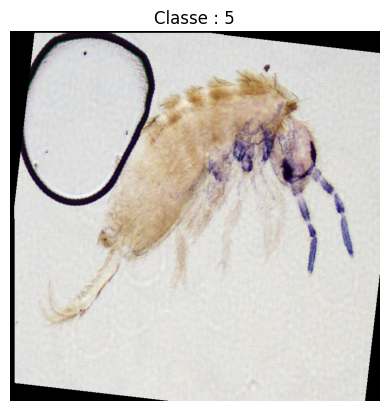

In [64]:
# Afficher une image
image, label = train_data_background[151]
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Classe : {label}")
plt.axis('off')
plt.show()

## Model

In [72]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

In [73]:
# Define a custom macro F1 metric
class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='f1_macro', **kwargs):
        super(F1Macro, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        # Initialize accumulators for true positives, false positives, and false negatives
        self.tp = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.fp = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.fn = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32)


    def update_state(self, y_true, y_pred, sample_weight=None):
      # Convert probabilities to predicted class indices
      y_pred = tf.argmax(y_pred, axis=1)
      y_true = tf.cast(y_true, tf.int64)

      # One-hot encode the labels
      y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes)
      y_pred_one_hot = tf.one_hot(y_pred, depth=self.num_classes)

      # Compute per-class true positives, false positives, and false negatives
      tp = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=0)
      fp = tf.reduce_sum((1 - y_true_one_hot) * y_pred_one_hot, axis=0)
      fn = tf.reduce_sum(y_true_one_hot * (1 - y_pred_one_hot), axis=0)

      # Update the metric variables in a vectorized manner
      self.tp.assign_add(tp)
      self.fp.assign_add(fp)
      self.fn.assign_add(fn)

    def result(self):
        # Compute precision and recall per class
        precision = tf.math.divide_no_nan(self.tp, self.tp + self.fp)
        recall = tf.math.divide_no_nan(self.tp, self.tp + self.fn)
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        # Return the macro-average F1 score
        return tf.reduce_mean(f1)

    def reset_states(self):
        for var in self.variables:
            var.assign(tf.zeros_like(var))

In [ ]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

# Construction de la tête de classification personnalisée + Batch Normalization
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)  # Ajout de la BN
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

# Définition du modèle complet
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Compilation du modèle avec un weight decay (via le paramètre "decay") sur Adam
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR, decay=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=[F1Macro(num_classes)]
)

# Entraînement du modèle avec enregistrement de la meilleure époque
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint(
        filepath="best_model_test_min3.h5",
        monitor="val_f1_macro",
        mode="max",
        save_best_only=True
    )]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


    218/Unknown 133s 349ms/step - f1_macro: 0.2826 - loss: 2.2225

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


218/218 ━━━━━━━━━━━━━━━━━━━━ 178s 557ms/step - f1_macro: 0.2829 - loss: 2.2214 - val_f1_macro: 0.0220 - val_loss: 7.7765
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 435ms/step - f1_macro: 0.4203 - loss: 1.6452 - val_f1_macro: 0.0220 - val_loss: 7.6793
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - f1_macro: 0.4912 - loss: 1.4835

218/218 ━━━━━━━━━━━━━━━━━━━━ 97s 447ms/step - f1_macro: 0.4913 - loss: 1.4834 - val_f1_macro: 0.0568 - val_loss: 9.2727
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - f1_macro: 0.5620 - loss: 1.2671

218/218 ━━━━━━━━━━━━━━━━━━━━ 96s 442ms/step - f1_macro: 0.5620 - loss: 1.2672 - val_f1_macro: 0.1866 - val_loss: 4.6517
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - f1_macro: 0.5882 - loss: 1.2207

218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 438ms/step - f1_macro: 0.5882 - loss: 1.2208 - val_f1_macro: 0.3818 - val_loss: 2.0319
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - f1_macro: 0.5749 - loss: 1.1944

218/218 ━━━━━━━━━━━━━━━━━━━━ 96s 438ms/step - f1_macro: 0.5750 - loss: 1.1944 - val_f1_macro: 0.4887 - val_loss: 1.4756
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - f1_macro: 0.5996 - loss: 1.1416

218/218 ━━━━━━━━━━━━━━━━━━━━ 97s 445ms/step - f1_macro: 0.5996 - loss: 1.1417 - val_f1_macro: 0.4908 - val_loss: 1.5127
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 425ms/step - f1_macro: 0.6505 - loss: 1.1057 - val_f1_macro: 0.4583 - val_loss: 2.3071
Epoch 9/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - f1_macro: 0.5769 - loss: 1.0841

218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 436ms/step - f1_macro: 0.5771 - loss: 1.0840 - val_f1_macro: 0.5052 - val_loss: 1.7045
Epoch 10/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - f1_macro: 0.6317 - loss: 1.0133

218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 433ms/step - f1_macro: 0.6318 - loss: 1.0132 - val_f1_macro: 0.5838 - val_loss: 1.7086
Epoch 11/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 432ms/step - f1_macro: 0.6751 - loss: 0.8393 - val_f1_macro: 0.4980 - val_loss: 2.2804
Epoch 12/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - f1_macro: 0.6669 - loss: 0.8990

218/218 ━━━━━━━━━━━━━━━━━━━━ 96s 440ms/step - f1_macro: 0.6671 - loss: 0.8989 - val_f1_macro: 0.6251 - val_loss: 1.2292
Epoch 13/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 92s 422ms/step - f1_macro: 0.6923 - loss: 0.8274 - val_f1_macro: 0.4563 - val_loss: 6.2809
Epoch 14/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 435ms/step - f1_macro: 0.7565 - loss: 0.7542 - val_f1_macro: 0.5336 - val_loss: 1.5863
Epoch 15/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 92s 423ms/step - f1_macro: 0.7130 - loss: 0.8439 - val_f1_macro: 0.6074 - val_loss: 1.5922
Epoch 16/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 93s 427ms/step - f1_macro: 0.7141 - loss: 0.7921 - val_f1_macro: 0.5270 - val_loss: 1.8387
Epoch 17/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 93s 428ms/step - f1_macro: 0.7367 - loss: 0.7544 - val_f1_macro: 0.4649 - val_loss: 2.8257
Epoch 18/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 93s 426ms/step - f1_macro: 0.7353 - loss: 0.7735 - val_f1_macro: 0.5296 - val_loss: 1.8652
Epoch 19/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 430ms/step - f1_macro: 0.7311 - loss: 0.749

In [ ]:

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

# Construction de la tête de classification + Batch Normalization
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Dropout à 0.2
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Compilation du modèle

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="sparse_categorical_crossentropy",
    metrics=[F1Macro(num_classes)]
)

# Entraînement du modèle avec enregistrement de la meilleure époque
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint(
        filepath="best_model_test_min3.h5",
        monitor="val_f1_macro",
        mode="max",
        save_best_only=True
    )]
)

Epoch 1/20
    218/Unknown 130s 345ms/step - f1_macro: 0.2746 - loss: 2.1879

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


218/218 ━━━━━━━━━━━━━━━━━━━━ 176s 557ms/step - f1_macro: 0.2750 - loss: 2.1870 - val_f1_macro: 0.0388 - val_loss: 3.1519
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 93s 428ms/step - f1_macro: 0.4383 - loss: 1.6046 - val_f1_macro: 0.0217 - val_loss: 6.1371
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 93s 428ms/step - f1_macro: 0.4483 - loss: 1.6401 - val_f1_macro: 0.0220 - val_loss: 9.6953
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - f1_macro: 0.5131 - loss: 1.3990

218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 433ms/step - f1_macro: 0.5132 - loss: 1.3988 - val_f1_macro: 0.2160 - val_loss: 2.6284
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - f1_macro: 0.5536 - loss: 1.1982

218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 432ms/step - f1_macro: 0.5535 - loss: 1.1986 - val_f1_macro: 0.3324 - val_loss: 2.5809
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - f1_macro: 0.5770 - loss: 1.1771

218/218 ━━━━━━━━━━━━━━━━━━━━ 96s 442ms/step - f1_macro: 0.5771 - loss: 1.1771 - val_f1_macro: 0.4123 - val_loss: 2.0974
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - f1_macro: 0.6063 - loss: 1.1150

218/218 ━━━━━━━━━━━━━━━━━━━━ 97s 442ms/step - f1_macro: 0.6063 - loss: 1.1149 - val_f1_macro: 0.4563 - val_loss: 2.1476
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - f1_macro: 0.6435 - loss: 1.0514

218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 435ms/step - f1_macro: 0.6434 - loss: 1.0516 - val_f1_macro: 0.5354 - val_loss: 2.1350
Epoch 9/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 431ms/step - f1_macro: 0.6351 - loss: 1.0131 - val_f1_macro: 0.5287 - val_loss: 1.7512
Epoch 10/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 93s 427ms/step - f1_macro: 0.6718 - loss: 0.9860 - val_f1_macro: 0.4443 - val_loss: 2.7434
Epoch 11/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - f1_macro: 0.6706 - loss: 0.9333

218/218 ━━━━━━━━━━━━━━━━━━━━ 92s 423ms/step - f1_macro: 0.6707 - loss: 0.9335 - val_f1_macro: 0.6031 - val_loss: 1.3246
Epoch 12/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 430ms/step - f1_macro: 0.6976 - loss: 0.8423 - val_f1_macro: 0.4617 - val_loss: 3.0461
Epoch 13/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 93s 428ms/step - f1_macro: 0.7103 - loss: 0.7930 - val_f1_macro: 0.5110 - val_loss: 1.6571
Epoch 14/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 432ms/step - f1_macro: 0.7415 - loss: 0.7391 - val_f1_macro: 0.6008 - val_loss: 1.2005
Epoch 15/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 431ms/step - f1_macro: 0.6916 - loss: 0.8435 - val_f1_macro: 0.5267 - val_loss: 2.2570
Epoch 16/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - f1_macro: 0.7369 - loss: 0.8266

218/218 ━━━━━━━━━━━━━━━━━━━━ 96s 442ms/step - f1_macro: 0.7369 - loss: 0.8264 - val_f1_macro: 0.6634 - val_loss: 1.2134
Epoch 17/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 92s 424ms/step - f1_macro: 0.7293 - loss: 0.7546 - val_f1_macro: 0.4454 - val_loss: 2.0186
Epoch 18/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 92s 422ms/step - f1_macro: 0.7495 - loss: 0.7899 - val_f1_macro: 0.2753 - val_loss: 7.4757
Epoch 19/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 431ms/step - f1_macro: 0.7404 - loss: 0.7644 - val_f1_macro: 0.6339 - val_loss: 1.2785
Epoch 20/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 430ms/step - f1_macro: 0.7421 - loss: 0.7294 - val_f1_macro: 0.6113 - val_loss: 1.3503


In [81]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


# 1) Fonction de calcul (et de lissage) de poids de classe

def compute_class_weights_smoothed(dataset, train_background):
    """
    Calcule et lisse les poids des classes pour éviter des valeurs trop extrêmes.
    - Ajoute la classe 8 avec la valeur len(train_background).
    - Calcule un poids brut = total_samples / nb_exemples_classe.
    - Lisse en prenant la racine carrée (sqrt), et normalise pour avoir une moyenne ~1.
    """
    class_counts = dataset.class_counts  # dict {classe: nb_exemples}
    total_samples = sum(class_counts.values())

    # Ajouter la classe 8
    class_counts[8] = len(train_background)

    # Poids bruts
    raw_weights = {cls: total_samples / count for cls, count in class_counts.items()}

    # Lissage : on prend la racine pour réduire l'écart entre petits et grands poids
    smoothed_weights = {cls: w**0.5 for cls, w in raw_weights.items()}

    # Normalisation : on ramène la moyenne des poids à 1 pour éviter d'énormes valeurs
    mean_w = sum(smoothed_weights.values()) / len(smoothed_weights)
    final_weights = {cls: w / mean_w for cls, w in smoothed_weights.items()}

    return final_weights


# 2) On récupère le dictionnaire {classe: poids} en utilisant la version lissée

class_weights = compute_class_weights_smoothed(train_dataset_label, train_background)


# 3) Modèle identique : ResNet50 + GlobalAveragePooling + Dense + BN + Dropout + Dense

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="sparse_categorical_crossentropy",
    metrics=[F1Macro(num_classes)]  # votre métrique perso
)


# 4) Callbacks : ModelCheckpoint + ReduceLROnPlateau pour scheduler

callbacks = [
    ModelCheckpoint(
        filepath="best_model_test_min7.h5",
        monitor="val_f1_macro",
        mode="max",
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_f1_macro',   # On peut monitorer la val_loss ou val_f1_macro
        factor=0.5,           # Divise le LR par 2
        patience=3,           # Après 3 époques sans amélioration
        verbose=1
    )
]

# 5) Entraînement

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    class_weight=class_weights,  # on applique la pondération lissée
    callbacks=callbacks
)

Epoch 1/20
    236/Unknown 129s 317ms/step - f1_macro: 0.2460 - loss: 2.0637

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


236/236 ━━━━━━━━━━━━━━━━━━━━ 177s 520ms/step - f1_macro: 0.2464 - loss: 2.0622 - val_f1_macro: 0.0738 - val_loss: 2.6148 - learning_rate: 5.0000e-05
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 422ms/step - f1_macro: 0.4989 - loss: 1.2103 - val_f1_macro: 0.0220 - val_loss: 5.8640 - learning_rate: 5.0000e-05
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 100s 423ms/step - f1_macro: 0.5342 - loss: 1.1570 - val_f1_macro: 0.0403 - val_loss: 7.6720 - learning_rate: 5.0000e-05
Epoch 4/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - f1_macro: 0.6182 - loss: 0.9395

236/236 ━━━━━━━━━━━━━━━━━━━━ 98s 415ms/step - f1_macro: 0.6180 - loss: 0.9403 - val_f1_macro: 0.1154 - val_loss: 7.8423 - learning_rate: 5.0000e-05
Epoch 5/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - f1_macro: 0.6495 - loss: 0.8431


Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 419ms/step - f1_macro: 0.6495 - loss: 0.8435 - val_f1_macro: 0.4242 - val_loss: 2.4914 - learning_rate: 5.0000e-05
Epoch 6/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - f1_macro: 0.6860 - loss: 0.7174

236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 419ms/step - f1_macro: 0.6862 - loss: 0.7175 - val_f1_macro: 0.6925 - val_loss: 1.2310 - learning_rate: 2.5000e-05
Epoch 7/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - f1_macro: 0.7226 - loss: 0.6369

236/236 ━━━━━━━━━━━━━━━━━━━━ 101s 426ms/step - f1_macro: 0.7227 - loss: 0.6371 - val_f1_macro: 0.7393 - val_loss: 1.2646 - learning_rate: 2.5000e-05
Epoch 8/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - f1_macro: 0.7443 - loss: 0.6002


Epoch 8: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
236/236 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - f1_macro: 0.7443 - loss: 0.6005 - val_f1_macro: 0.7614 - val_loss: 0.9634 - learning_rate: 2.5000e-05
Epoch 9/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - f1_macro: 0.8108 - loss: 0.5059

236/236 ━━━━━━━━━━━━━━━━━━━━ 100s 426ms/step - f1_macro: 0.8106 - loss: 0.5061 - val_f1_macro: 0.8099 - val_loss: 0.7788 - learning_rate: 1.2500e-05
Epoch 10/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - f1_macro: 0.7935 - loss: 0.4972

236/236 ━━━━━━━━━━━━━━━━━━━━ 100s 424ms/step - f1_macro: 0.7936 - loss: 0.4971 - val_f1_macro: 0.8216 - val_loss: 0.7499 - learning_rate: 1.2500e-05
Epoch 11/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - f1_macro: 0.8081 - loss: 0.4768
Epoch 11: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 420ms/step - f1_macro: 0.8081 - loss: 0.4768 - val_f1_macro: 0.8136 - val_loss: 0.7613 - learning_rate: 1.2500e-05
Epoch 12/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - f1_macro: 0.8094 - loss: 0.4522

236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 421ms/step - f1_macro: 0.8095 - loss: 0.4524 - val_f1_macro: 0.8256 - val_loss: 0.7489 - learning_rate: 6.2500e-06
Epoch 13/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 100s 422ms/step - f1_macro: 0.8258 - loss: 0.4178 - val_f1_macro: 0.8086 - val_loss: 0.7701 - learning_rate: 6.2500e-06
Epoch 14/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - f1_macro: 0.8581 - loss: 0.3408


Epoch 14: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 420ms/step - f1_macro: 0.8580 - loss: 0.3410 - val_f1_macro: 0.8439 - val_loss: 0.7020 - learning_rate: 6.2500e-06
Epoch 15/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 100s 422ms/step - f1_macro: 0.8538 - loss: 0.3521 - val_f1_macro: 0.8387 - val_loss: 0.8090 - learning_rate: 3.1250e-06
Epoch 16/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 98s 413ms/step - f1_macro: 0.8423 - loss: 0.3653 - val_f1_macro: 0.8294 - val_loss: 0.7264 - learning_rate: 3.1250e-06
Epoch 17/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - f1_macro: 0.8477 - loss: 0.3698
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 418ms/step - f1_macro: 0.8477 - loss: 0.3699 - val_f1_macro: 0.8406 - val_loss: 0.6870 - learning_rate: 3.1250e-06
Epoch 18/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 99s 419ms/step - f1_macro: 0.8485 - loss: 0.3630 - val_f1_macro: 0.8255 - val_loss: 0.7086 - learnin

M1 : 10 epoche , 0,62

##)Affichage TSNE

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━

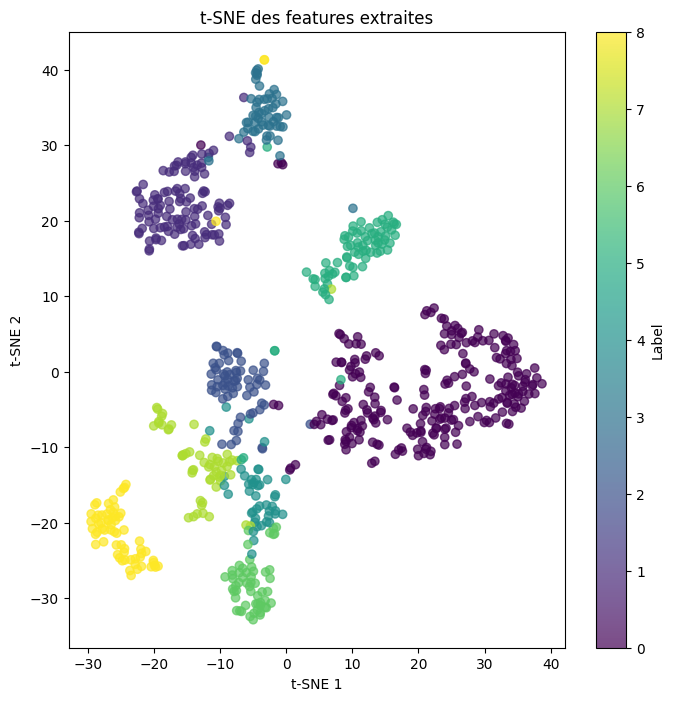

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import tensorflow as tf

# 1. Créer un modèle extracteur de features en prenant la sortie de la couche Dense(512, activation="relu")
# Ici, on sait que la couche Dense(512) est la troisième dernière couche du modèle (model.layers[-3])
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

# 2. Fonction pour extraire les features et labels depuis un tf.data.Dataset
def extract_features(dataset, extractor):
    features = []
    labels = []
    for batch_images, batch_labels in dataset:
        # Extraire les features avec le feature extractor
        feats = extractor.predict(batch_images)
        features.append(feats)
        labels.append(batch_labels.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extraction des features sur le dataset d'entraînement (train_ds)
features, labels = extract_features(train_ds, feature_extractor)
print("Shape des features extraites :", features.shape)
print("Nombre de samples :", features.shape[0])

# 3. Réduction de dimension avec t-SNE en 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# 4. Affichage du t-SNE
plt.figure(figsize=(8, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label')
plt.title("t-SNE des features extraites")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

tsne sur la validation


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━

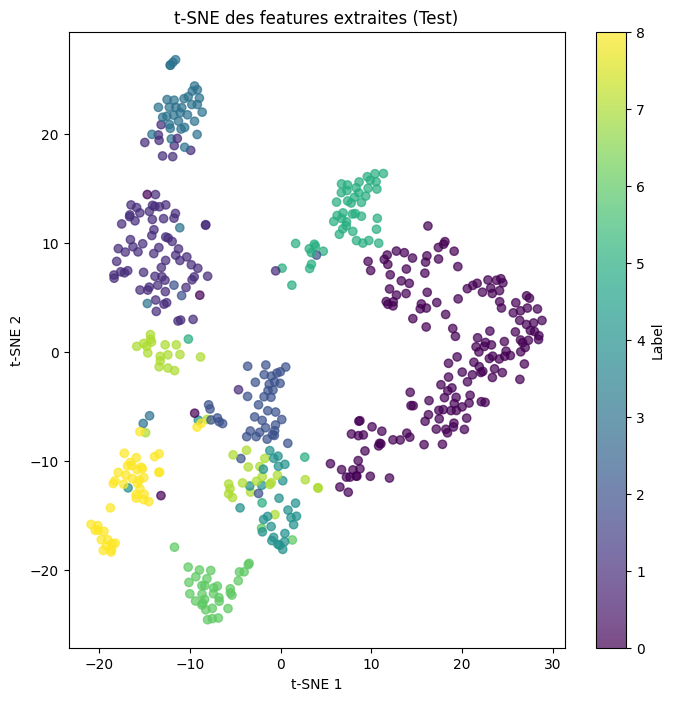

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import tensorflow as tf

# 1. Créer un modèle extracteur de features en prenant la sortie de la couche Dense(512, activation="relu")

feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

# 2. Fonction pour extraire les features et labels depuis un tf.data.Dataset
def extract_features(dataset, extractor):
    features = []
    labels = []
    for batch_images, batch_labels in dataset:
        # Extraire les features avec le feature extractor
        feats = extractor.predict(batch_images)
        features.append(feats)
        labels.append(batch_labels.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extraction des features sur le dataset de test (test_ds)
features_test, labels_test = extract_features(test_ds, feature_extractor)
print("Shape des features extraites (test) :", features_test.shape)
print("Nombre de samples (test) :", features_test.shape[0])

# 3. Réduction de dimension avec t-SNE en 2D
tsne = TSNE(n_components=2, random_state=42)
features_test_2d = tsne.fit_transform(features_test)

# 4. Affichage du t-SNE sur le jeu de test
plt.figure(figsize=(8, 8))
scatter = plt.scatter(features_test_2d[:, 0], features_test_2d[:, 1], c=labels_test, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label')
plt.title("t-SNE des features extraites (Test)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

##III)essai

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━

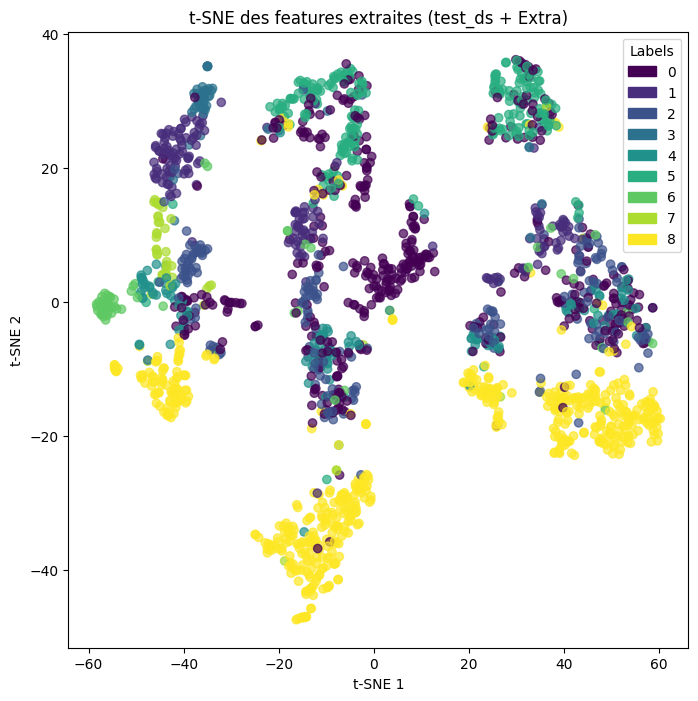

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

# Paramètres globaux
TARGET_HEIGHT = 800
TARGET_WIDTH  = 800


# On définit le feature extractor à partir de la 3ème dernière couche (Dense(512, activation="relu"))
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

# Fonction d'extraction de features depuis un tf.data.Dataset
def extract_features(dataset, extractor):
    features = []
    labels = []
    for batch_images, batch_labels in dataset:
        feats = extractor.predict(batch_images)
        features.append(feats)
        labels.append(batch_labels.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extraction des features sur l'ensemble test_ds
features_test, labels_test = extract_features(test_ds, feature_extractor)
print("Shape des features extraites (test_ds):", features_test.shape)
print("Nombre de samples (test_ds):", features_test.shape[0])

#Chargement des images supplémentaires et attribution de leur label via CSV
EXTRA_FOLDER = "/content/drive/MyDrive/challenge_deep/dataset/test/datatest"
extra_files = [os.path.join(EXTRA_FOLDER, f) for f in os.listdir(EXTRA_FOLDER) if f.lower().endswith('.jpg')]
print("Nombre d'images supplémentaires :", len(extra_files))

# Lecture du CSV qui contient les colonnes "idx" (nom de fichier sans .jpg) et "predicted_label"
csv_path = "/content/drive/MyDrive/challenge_deep/dataset/labels1.csv"
label_df = pd.read_csv(csv_path)
# Création d'un dictionnaire : { "idx" : predicted_label }
label_mapping = dict(zip(label_df['idx'].astype(str), label_df['gt']))

def load_and_preprocess_image(filepath):
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0
    return image

features_extra = []
labels_extra = []
for filepath in extra_files:
    # Récupérer l'identifiant de l'image (nom sans extension)
    idx = os.path.splitext(os.path.basename(filepath))[0]
    # Si l'image est présente dans le CSV, on récupère son label
    if idx in label_mapping:
        label = label_mapping[idx]
    else:
        continue  # On ignore l'image si elle n'est pas dans le CSV
    image = load_and_preprocess_image(filepath)
    image = tf.expand_dims(image, axis=0)  # Ajouter la dimension batch
    feats = feature_extractor.predict(image)
    features_extra.append(feats)
    labels_extra.append(label)

if features_extra:
    features_extra = np.concatenate(features_extra, axis=0)
    labels_extra = np.array(labels_extra)
    print("Shape des features extraites (extra):", features_extra.shape)
else:
    features_extra = np.empty((0, features_test.shape[1]))
    labels_extra = np.empty((0,), dtype=np.int32)
    print("Aucune image extra traitée.")

# Combinaison des features et labels
features_combined = np.concatenate([features_test, features_extra], axis=0)
labels_combined = np.concatenate([labels_test, labels_extra], axis=0)

# Création d'un masque booléen pour différencier les images issues de test_ds et celles extra (facultatif ici)
mask_extra = np.concatenate([np.zeros(features_test.shape[0], dtype=bool),
                              np.ones(features_extra.shape[0], dtype=bool)])

#Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_combined_2d = tsne.fit_transform(features_combined)

#Mapping couleur personnalisé
# Utilisation de la colormap "viridis" pour toutes les images (les labels 0 à 8)
def map_color(label):
    cmap = plt.get_cmap("viridis", 9)
    return cmap(label)

colors = [map_color(l) for l in labels_combined]

#Affichage du t-SNE
plt.figure(figsize=(8, 8))
plt.scatter(features_combined_2d[:, 0], features_combined_2d[:, 1], c=colors, alpha=0.7)
plt.title("t-SNE des features extraites (test_ds + Extra)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

# Création d'une légende personnalisée
import matplotlib.patches as mpatches
legend_entries = []
for i in range(9):
    patch = mpatches.Patch(color=plt.get_cmap("viridis", 9)(i), label=str(i))
    legend_entries.append(patch)
plt.legend(handles=legend_entries, title="Labels")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━

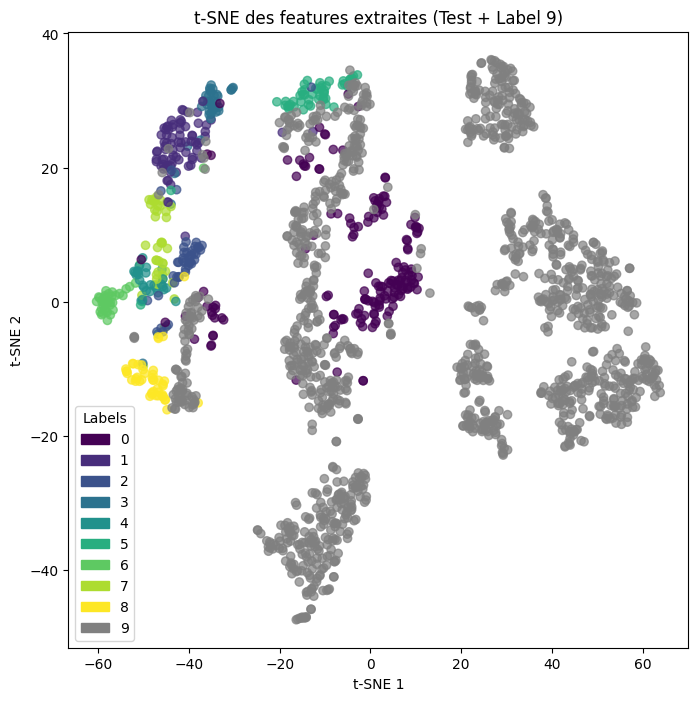

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Paramètres globaux
TARGET_HEIGHT = 800
TARGET_WIDTH  = 800

# On suppose que "model" est déjà entraîné et défini,
# et que "feature_extractor" est la sortie de la couche Dense(512, activation="relu")
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

#  Fonction d'extraction de features depuis un tf.data.Dataset
def extract_features(dataset, extractor):
    features = []
    labels = []
    for batch_images, batch_labels in dataset:
        feats = extractor.predict(batch_images)
        features.append(feats)
        labels.append(batch_labels.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extraction des features sur le dataset de test (test_ds)
features_test, labels_test = extract_features(test_ds, feature_extractor)
print("Shape des features extraites (test):", features_test.shape)
print("Nombre de samples (test):", features_test.shape[0])

# -Chargement des images supplémentaires dont on souhaite forcer le label 9

LABEL9_FOLDER = "/content/drive/MyDrive/challenge_deep/dataset/test/datatest"
label9_files = [os.path.join(LABEL9_FOLDER, f) for f in os.listdir(LABEL9_FOLDER) if f.lower().endswith('.jpg')]
print("Nombre d'images supplémentaires pour le label 9 :", len(label9_files))

def load_and_preprocess_image(filepath):
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    # Redimensionnement avec padding
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0  # Normalisation [0,1]
    return image

# Extraction des features pour les images de "label 9"
features_label9 = []
for filepath in label9_files:
    image = load_and_preprocess_image(filepath)
    image = tf.expand_dims(image, axis=0)  # Ajout de la dimension batch
    feats = feature_extractor.predict(image)
    features_label9.append(feats)
features_label9 = np.concatenate(features_label9, axis=0)
# On force le label 9 pour toutes ces images
labels_label9 = np.full((features_label9.shape[0],), 9)

# --- Combinaison des features et labels ---
features_combined = np.concatenate([features_test, features_label9], axis=0)
labels_combined = np.concatenate([labels_test, labels_label9], axis=0)

# --- Réduction de dimension avec t-SNE ---
tsne = TSNE(n_components=2, random_state=42)
features_combined_2d = tsne.fit_transform(features_combined)

# --- Création d'une mapping couleur personnalisée ---
# Pour les labels 0 à 8, on utilise la colormap "viridis"
# Pour le label 9, on force la couleur "gray"
def map_label_to_color(label):
    if label == 9:
        return "gray"
    else:
        cmap = plt.get_cmap("viridis", 9)
        return cmap(label)

colors = [map_label_to_color(l) for l in labels_combined]

# --- Affichage du t-SNE ---
plt.figure(figsize=(8, 8))
plt.scatter(features_combined_2d[:, 0], features_combined_2d[:, 1], c=colors, alpha=0.7)
plt.title("t-SNE des features extraites (Test + Label 9)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

# Création d'une légende personnalisée
import matplotlib.patches as mpatches
legend_labels = list(range(9)) + [9]
legend_patches = [mpatches.Patch(color=map_label_to_color(i), label=str(i)) for i in legend_labels]
plt.legend(handles=legend_patches, title="Labels")
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/challenge_deep/model_base1.h5")

In [ ]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

# Construction de la tête de classification personnalisée
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

# Définition du modèle complet
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Compilation du modèle avec l'optimiseur Adam, la loss sparse categorical crossentropy
# et notre métrique personnalisée F1 Macro
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=[F1Macro(num_classes)]
)

# Entraînement du modèle sur l'ensemble complet des données (full_ds)
history = model.fit(
    full_ds,
    epochs=EPOCH
)

In [ ]:
!pip install optuna xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.4 MB/s eta 0:00:00


##)XGBOOST sans pca


In [ ]:
!pip install optuna xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.5 MB/s eta 0:00:00


In [82]:
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf

# Assurez-vous que NUM_CLASSES est défini (ici 9)
NUM_CLASSES = 9

########################################
# 1. Définir le feature extractor
########################################
# On suppose que 'model' est déjà défini et entraîné.
# Ici, nous prenons la sortie de la 3ème dernière couche (Dense(512, activation="relu"))
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

########################################
# 2. Extraction des features depuis train_ds
########################################
def extract_features(dataset, extractor):
    features = []
    labels = []
    for images, labs in dataset:
        feats = extractor.predict(images)
        features.append(feats)
        labels.append(labs.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

print("Extraction des features sur l'ensemble train_ds...")
features, labels = extract_features(train_ds, feature_extractor)
print("Shape des features extraites :", features.shape)
print("Nombre de samples :", features.shape[0])

########################################
# 3. Création des splits internes avec stratification
########################################
# Réserver 20% des données pour le test interne (que le modèle ne verra pas lors de l'optimisation)
X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.20, random_state=42, stratify=labels
)

print("Taille X_train:", X_train.shape)
print("Taille X_valid:", X_valid.shape)


########################################
# 4. Optimisation avec Optuna sur le split train/validation
########################################
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': NUM_CLASSES,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'gamma': trial.suggest_float('gamma', 1e-3, 1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train, verbose=False)
    y_pred = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred, average='macro')
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
best_trial = study.best_trial
print("  F1 Macro sur validation (optimisation): {:.4f}".format(best_trial.value))
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

########################################
# 5. Évaluation finale sur test_ds final
########################################
# Extraction des features sur test_ds final (qui reste intact)
features_test_final, labels_test_final = extract_features(test_ds, feature_extractor)
print("Shape des features extraites (test_ds):", features_test_final.shape)
print("Nombre de samples (test_ds):", features_test_final.shape[0])

# Entraîner le XGBoost final sur l’ensemble complet des features extraites de train_ds
xgb_clf_final = xgb.XGBClassifier(
    **best_trial.params,
    objective='multi:softprob',
    num_class=NUM_CLASSES,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_clf_final.fit(features, labels)

# Évaluation finale sur test_ds
y_pred_test_final = xgb_clf_final.predict(features_test_final)
final_f1 = f1_score(labels_test_final, y_pred_test_final, average='macro')
print("Final F1 Macro sur test_ds:", final_f1)
print("Classification report (test_ds):\n", classification_report(labels_test_final, y_pred_test_final))

Extraction des features sur l'ensemble train_ds...


KeyboardInterrupt: 

In [83]:
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf

# ===========================================
# PARAMÈTRES GLOBAUX
# ===========================================
NUM_CLASSES = 9  # Nombre total de classes
HIGH_WEIGHT = 3.0  # Facteur multiplicatif pour les classes 4 et 7

# ===========================================
# 1. Définir le feature extractor (CNN)
# ===========================================
# On suppose que 'model' est déjà défini et entraîné.
# Ici, nous prenons la sortie de la 3ème dernière couche (Dense(512, activation="relu"))
feature_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-3].output
)

# ===========================================
# 2. Extraction des features depuis train_ds
# ===========================================
def extract_features(dataset, extractor):
    features = []
    labels = []
    for images, labs in dataset:
        feats = extractor.predict(images)
        features.append(feats)
        labels.append(labs.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

print("Extraction des features sur l'ensemble train_ds...")
features, labels = extract_features(train_ds, feature_extractor)
print("Shape des features extraites :", features.shape)
print("Nombre de samples :", features.shape[0])

# ===========================================
# 3. Création des splits internes
#    (80% train, 20% validation)
# ===========================================
X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.20, random_state=42, stratify=labels
)
print("Taille X_train:", X_train.shape)
print("Taille X_valid:", X_valid.shape)

# ===========================================
# 4. OPTUNA + XGBoost (avec sample_weight)
# ===========================================
def objective(trial):
    # Hyperparamètres à optimiser
    params = {
        'objective': 'multi:softprob',     # classification multi-classes standard
        'num_class': NUM_CLASSES,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'gamma': trial.suggest_float('gamma', 1e-3, 1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Création du vecteur de weights : on met un poids élevé pour les classes 4 et 7
    sample_weights = np.ones_like(y_train, dtype=float)
    sample_weights[y_train == 4] = HIGH_WEIGHT
    sample_weights[y_train == 7] = HIGH_WEIGHT

    # Entraînement du XGBoost
    clf = xgb.XGBClassifier(**params)
    clf.fit(
        X_train, y_train,
        sample_weight=sample_weights,
        verbose=False
    )

    # Prédiction sur la validation
    y_pred = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred, average='macro')
    return score

# Lancement d'Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
best_trial = study.best_trial
print("  F1 Macro sur validation (optimisation): {:.4f}".format(best_trial.value))
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

# ===========================================
# 5. Évaluation finale sur test_ds
# ===========================================
# Extraction des features sur test_ds
features_test_final, labels_test_final = extract_features(test_ds, feature_extractor)
print("Shape des features extraites (test_ds):", features_test_final.shape)
print("Nombre de samples (test_ds):", features_test_final.shape[0])

# On réentraîne XGBClassifier final sur l'ensemble (X_train+X_valid)
X_full = np.concatenate([X_train, X_valid], axis=0)
y_full = np.concatenate([y_train, y_valid], axis=0)

# On reprend les meilleurs hyperparamètres
best_params = dict(best_trial.params)
best_params.update({
    'objective': 'multi:softprob',
    'num_class': NUM_CLASSES,
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'random_state': 42
})

# Vecteur de sample weights sur X_full
sample_weights_full = np.ones_like(y_full, dtype=float)
sample_weights_full[y_full == 4] = HIGH_WEIGHT
sample_weights_full[y_full == 7] = HIGH_WEIGHT

xgb_clf_final = xgb.XGBClassifier(**best_params)
xgb_clf_final.fit(
    X_full, y_full,
    sample_weight=sample_weights_full,
    verbose=False
)

# Évaluation finale sur test_ds
y_pred_test_final = xgb_clf_final.predict(features_test_final)
final_f1 = f1_score(labels_test_final, y_pred_test_final, average='macro')
print("Final F1 Macro sur test_ds:", final_f1)
print("Classification report (test_ds):\n",
      classification_report(labels_test_final, y_pred_test_final))

Extraction des features sur l'ensemble train_ds...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1

[I 2025-04-02 03:56:47,830] A new study created in memory with name: no-name-991b6ee3-bbfc-4413-b480-e6ebaf718289


Shape des features extraites : (941, 512)
Nombre de samples : 941
Taille X_train: (752, 512)
Taille X_valid: (189, 512)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:56:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 03:57:00,027] Trial 0 finished with value: 0.9326088803318405 and parameters: {'max_depth': 10, 'learning_rate': 0.00230425916843704, 'n_estimators': 147, 'gamma': 0.27194924712062846, 'min_child_weight': 1, 'subsample': 0.6181815271797972, 'colsample_bytree': 0.72352564095605}. Best is trial 0 with value: 0.9326088803318405.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:57:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 03:57:03,745] Trial 1 finished with value: 0.9020886176790044 and parameters: {'max_depth': 7, 'learning_rate': 0.0017577616075437688, 'n_estimators': 77, 'gamma': 0.16064991097019815, 'min_child_weight': 4, 'subsample':

Best trial:
  F1 Macro sur validation (optimisation): 0.9694
  Best hyperparameters:
    max_depth: 6
    learning_rate: 0.048769177541513734
    n_estimators: 214
    gamma: 0.063755952327606
    min_child_weight: 5
    subsample: 0.8439688028999658
    colsample_bytree: 0.6060463890320489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:03:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final F1 Macro sur test_ds: 0.8018272277076749
Classification report (test_ds):
               precision    recall  f1-score   support

           0       0.72      0.84      0.78       191
           1       0.85      0.87      0.86        92
           2       0.87      0.65      0.74        51
           3       0.95      0.81      0.88        43
           4       0.64      0.64      0.64        33
           5       0.83      0.68      0.75        59
           6       0.97      0.88      0.93        43
           7       0.67      0.68      0.67        47
           8       0.97      0.99      0.98        69

    accuracy                           0.81       628
   macro avg       0.83      0.78      0.80       628
weighted avg       0.82      0.81      0.81       628



In [84]:
 !pip install shap

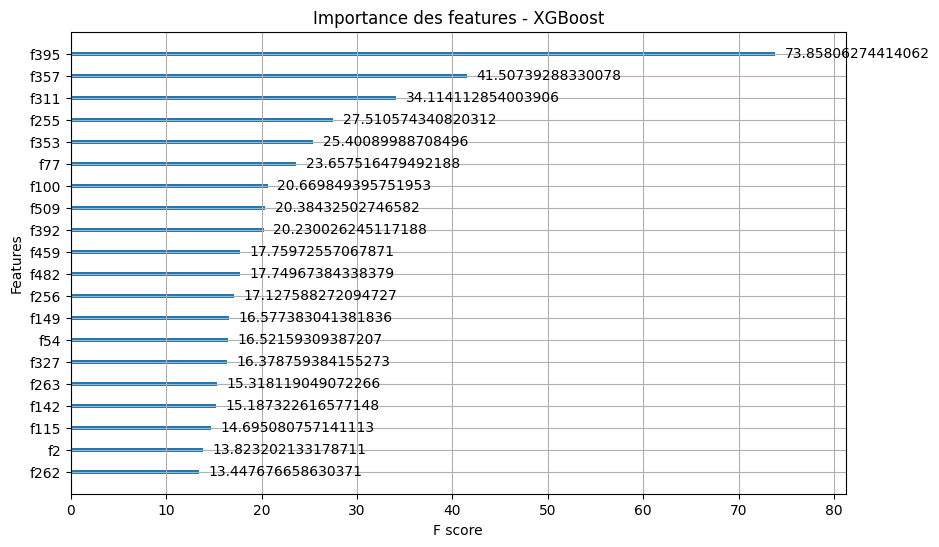

In [93]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Afficher l'importance des features selon le modèle XGBoost
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgb_clf_final, ax=ax, max_num_features=20, importance_type='gain')
plt.title("Importance des features - XGBoost")
plt.show()

test sur les classe 4 et 7 sur les poids augmenter

In [48]:
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf

# ===========================================
# PARAMÈTRES GLOBAUX
# ===========================================
NUM_CLASSES = 9  # Nombre total de classes

# ===========================================
# 1. Définir le feature extractor (CNN)
# ===========================================
# On suppose que 'model' est déjà défini et entraîné.
# Ici, nous prenons la sortie de la 3ème dernière couche (Dense(512, activation="relu"))
feature_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-3].output
)

# ===========================================
# 2. Extraction des features depuis train_ds
# ===========================================
def extract_features(dataset, extractor):
    features = []
    labels = []
    for images, labs in dataset:
        feats = extractor.predict(images)
        features.append(feats)
        labels.append(labs.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

print("Extraction des features sur l'ensemble train_ds...")
features, labels = extract_features(train_ds, feature_extractor)
print("Shape des features extraites :", features.shape)
print("Nombre de samples :", features.shape[0])

# ===========================================
# 3. Création des splits internes (80% train, 20% validation)
# ===========================================
X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.20, random_state=42, stratify=labels
)
print("Taille X_train:", X_train.shape)
print("Taille X_valid:", X_valid.shape)

# ===========================================
# 4. OPTUNA + XGBoost (avec sample_weight)
# ===========================================
def objective(trial):
    # Hyperparamètres à optimiser
    params = {
        'objective': 'multi:softprob',     # classification multi-classes standard
        'num_class': NUM_CLASSES,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'gamma': trial.suggest_float('gamma', 1e-3, 1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Création du vecteur de sample weights :
    # - On attribue 5.0 à la classe 4
    # - On attribue 4.0 à la classe 7
    sample_weights = np.ones_like(y_train, dtype=float)
    sample_weights[y_train == 4] = 7.0
    sample_weights[y_train == 7] = 4.0

    # Entraînement du XGBoost
    clf = xgb.XGBClassifier(**params)
    clf.fit(
        X_train, y_train,
        sample_weight=sample_weights,
        verbose=False
    )

    # Prédiction sur la validation
    y_pred = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred, average='macro')
    return score

# Lancement d'Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
best_trial = study.best_trial
print("  F1 Macro sur validation (optimisation): {:.4f}".format(best_trial.value))
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

# ===========================================
# 5. Évaluation finale sur test_ds
# ===========================================
# Extraction des features sur test_ds
features_test_final, labels_test_final = extract_features(test_ds, feature_extractor)
print("Shape des features extraites (test_ds):", features_test_final.shape)
print("Nombre de samples (test_ds):", features_test_final.shape[0])

# Réentraînement du XGBClassifier final sur l'ensemble (X_train + X_valid)
X_full = np.concatenate([X_train, X_valid], axis=0)
y_full = np.concatenate([y_train, y_valid], axis=0)

# Reprise des meilleurs hyperparamètres
best_params = dict(best_trial.params)
best_params.update({
    'objective': 'multi:softprob',
    'num_class': NUM_CLASSES,
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'random_state': 42
})

# Création du vecteur de sample weights sur X_full
sample_weights_full = np.ones_like(y_full, dtype=float)
sample_weights_full[y_full == 4] = 7.0
sample_weights_full[y_full == 7] = 4.0

xgb_clf_final = xgb.XGBClassifier(**best_params)
xgb_clf_final.fit(
    X_full, y_full,
    sample_weight=sample_weights_full,
    verbose=False
)

# Évaluation finale sur test_ds
y_pred_test_final = xgb_clf_final.predict(features_test_final)
final_f1 = f1_score(labels_test_final, y_pred_test_final, average='macro')
print("Final F1 Macro sur test_ds:", final_f1)
print("Classification report (test_ds):\n",
      classification_report(labels_test_final, y_pred_test_final))

Extraction des features sur l'ensemble train_ds...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1

[I 2025-04-02 01:11:12,525] A new study created in memory with name: no-name-257afe0b-218a-4dd2-8987-168084c28262


Shape des features extraites : (807, 512)
Nombre de samples : 807
Taille X_train: (645, 512)
Taille X_valid: (162, 512)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:11:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 01:11:18,207] Trial 0 finished with value: 0.8775333089342752 and parameters: {'max_depth': 4, 'learning_rate': 0.001038630294426354, 'n_estimators': 127, 'gamma': 0.005573712197765921, 'min_child_weight': 2, 'subsample': 0.6304834041625937, 'colsample_bytree': 0.6654311180835477}. Best is trial 0 with value: 0.8775333089342752.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:11:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 01:11:22,618] Trial 1 finished with value: 0.8915732279019708 and parameters: {'max_depth': 6, 'learning_rate': 0.04311544939918158, 'n_estimators': 133, 'gamma': 0.13949691168834621, 'min_child_weight': 9, 'subsample

Best trial:
  F1 Macro sur validation (optimisation): 0.9461
  Best hyperparameters:
    max_depth: 10
    learning_rate: 0.06197988403205064
    n_estimators: 141
    gamma: 0.08756446470715144
    min_child_weight: 3
    subsample: 0.5120979356332038
    colsample_bytree: 0.5477580786322422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:21:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final F1 Macro sur test_ds: 0.7987986455592426
Classification report (test_ds):
               precision    recall  f1-score   support

           0       0.74      0.79      0.76       166
           1       0.84      0.87      0.85        77
           2       0.84      0.73      0.78        44
           3       0.85      0.89      0.87        38
           4       0.73      0.66      0.69        29
           5       0.86      0.73      0.79        51
           6       0.86      0.86      0.86        36
           7       0.64      0.61      0.62        38
           8       0.94      0.98      0.96        59

    accuracy                           0.80       538
   macro avg       0.81      0.79      0.80       538
weighted avg       0.80      0.80      0.80       538



NameError: name 'xgb_clf' is not defined

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

# Chemin vers le dossier de test (images non étiquetées)
TEST_FOLDER = "/content/drive/MyDrive/challenge_deep/dataset/test/datatest"

# Taille cible pour le redimensionnement (idem que pour l'entraînement)
TARGET_HEIGHT = 800
TARGET_WIDTH  = 800

def load_and_preprocess_image(filepath):
    """
    Charge une image depuis le disque, la redimensionne avec padding pour TARGET_HEIGHT x TARGET_WIDTH,
    et normalise les valeurs de pixels dans [0,1].
    """
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    # Redimensionner avec padding pour préserver le ratio d'aspect
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0  # Normalisation
    return image

# Récupérer la liste de toutes les images de test
test_files = [os.path.join(TEST_FOLDER, f) for f in os.listdir(TEST_FOLDER) if f.lower().endswith('.jpg')]
print(f"Found {len(test_files)} test images.")

# Extraction des features via le feature extractor pour chaque image de test
# (On suppose que 'feature_extractor' et 'xgb_clf' sont déjà définis et entraînés)
test_features = []
test_ids = []

for filepath in test_files:
    # Charger et prétraiter l'image
    image = load_and_preprocess_image(filepath)
    # Ajouter une dimension de batch
    image = tf.expand_dims(image, axis=0)
    # Extraire les features avec le feature extractor
    feats = feature_extractor.predict(image)
    test_features.append(feats)
    # Extraire l'identifiant (nom du fichier sans extension)
    idx = os.path.splitext(os.path.basename(filepath))[0]
    test_ids.append(idx)

# Concaténer les features en un tableau numpy
test_features = np.concatenate(test_features, axis=0)
print("Test features shape:", test_features.shape)

# Utiliser le classificateur XGBoost pour prédire sur ces features
pred_labels = xgb_clf_final.predict(test_features)

# Préparer les prédictions dans un DataFrame
predictions = []
for idx, label in zip(test_ids, pred_labels):
    predictions.append({'idx': idx, 'gt': int(label)})

pred_df = pd.DataFrame(predictions)

# Enregistrer le CSV sous le nom predictions_v1.csv dans votre Drive
output_csv = "/content/drive/MyDrive/challenge_deep/predictions_vFin.csv"
pred_df.to_csv(output_csv, index=False)
print("Saved predictions_v1.csv")

Found 1344 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

## full train

In [ ]:
# Définition du modèle basé sur ResNet50

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

# Construction de la tête de classification personnalisée
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

# Définition du modèle complet
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Compilation du modèle avec l'optimiseur Adam, la loss sparse categorical crossentropy
# et notre métrique personnalisée F1 Macro
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=[F1Macro(num_classes)]
)

# Entraînement du modèle sur l'ensemble complet des données (full_ds)
history = model.fit(
    full_ds,
    epochs=20
)

Epoch 1/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 157s 262ms/step - f1_macro: 0.3111 - loss: 1.7112
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


392/392 ━━━━━━━━━━━━━━━━━━━━ 99s 253ms/step - f1_macro: 0.5972 - loss: 0.9752
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 100s 254ms/step - f1_macro: 0.6694 - loss: 0.8259
Epoch 4/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 99s 252ms/step - f1_macro: 0.7359 - loss: 0.7129
Epoch 5/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 100s 254ms/step - f1_macro: 0.7478 - loss: 0.6317
Epoch 6/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 101s 257ms/step - f1_macro: 0.7739 - loss: 0.5708
Epoch 7/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 99s 252ms/step - f1_macro: 0.8153 - loss: 0.5146
Epoch 8/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 99s 251ms/step - f1_macro: 0.7994 - loss: 0.5230
Epoch 9/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 102s 259ms/step - f1_macro: 0.8185 - loss: 0.4474
Epoch 10/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 100s 255ms/step - f1_macro: 0.8459 - loss: 0.3922
Epoch 11/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 98s 249ms/step - f1_macro: 0.8600 - loss: 0.3354
Epoch 12/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 100s 256ms/step - f1_macro: 0.8593 - loss: 0.3722
Epoch 13/20
392/392 ━━━

In [ ]:
# Sauvegarder le modèle dans le répertoire "challenge_deep" sous le nom "CNN_full.keras"
save_path = '/content/drive/MyDrive/challenge_deep/modele entrainé/CNN_full_labélisé.keras'
model.save(save_path)
print(f"Modèle sauvegardé sous {save_path}")

Modèle sauvegardé sous /content/drive/MyDrive/challenge_deep/modele entrainé/CNN_full_labélisé.keras


In [ ]:
!pip install optuna xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf

# On s'assure que NUM_CLASSES est défini (ici 9)
NUM_CLASSES = 9

########################################
# 1. Définir le feature extractor
########################################
# On suppose que 'model' est déjà défini et entraîné.
# Ici, nous prenons la sortie de la 3ème dernière couche (Dense(512, activation="relu"))
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

########################################
# 2. Extraction des features depuis full_ds
########################################
def extract_features(dataset, extractor):
    features = []
    labels = []
    for images, labs in dataset:
        feats = extractor.predict(images)
        features.append(feats)
        labels.append(labs.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

print("Extraction des features sur l'ensemble full_ds...")
features, labels = extract_features(full_ds, feature_extractor)
print("Shape des features extraites :", features.shape)
print("Nombre de samples :", features.shape[0])

########################################
# 3. Création d'un split interne (train/validation) avec stratification
########################################
# On réserve 20% des données pour la validation (pour l'optimisation via Optuna)
X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.20, random_state=42, stratify=labels
)
print("Taille X_train:", X_train.shape)
print("Taille X_valid:", X_valid.shape)

########################################
# 4. Optimisation avec Optuna sur le split train/validation
########################################
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': NUM_CLASSES,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'gamma': trial.suggest_float('gamma', 1e-3, 1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train, verbose=False)
    y_pred = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred, average='macro')
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
best_trial = study.best_trial
print("  F1 Macro sur validation (optimisation): {:.4f}".format(best_trial.value))
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

########################################
# 5. Entraînement final du XGBoost sur l'ensemble complet (full_ds)
########################################
xgb_clf_final = xgb.XGBClassifier(
    **best_trial.params,
    objective='multi:softprob',
    num_class=NUM_CLASSES,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_clf_final.fit(features, labels)

########################################
# 6. Évaluation finale sur le split de validation interne
########################################
y_pred_valid = xgb_clf_final.predict(X_valid)
final_f1 = f1_score(y_valid, y_pred_valid, average='macro')
print("Final F1 Macro sur validation split:", final_f1)
print("Classification report (validation split):\n", classification_report(y_valid, y_pred_valid))

Extraction des features sur l'ensemble full_ds...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/

[I 2025-03-31 15:20:24,833] A new study created in memory with name: no-name-02044568-dd2c-475b-bf65-b340ab679499


Shape des features extraites : (1568, 512)
Nombre de samples : 1568
Taille X_train: (1254, 512)
Taille X_valid: (314, 512)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:20:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-31 15:20:28,855] Trial 0 finished with value: 0.8680840573467379 and parameters: {'max_depth': 8, 'learning_rate': 0.09900927917545868, 'n_estimators': 164, 'gamma': 0.0023362621095256524, 'min_child_weight': 3, 'subsample': 0.8203598394383449, 'colsample_bytree': 0.6107711691927151}. Best is trial 0 with value: 0.8680840573467379.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:20:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-31 15:20:42,397] Trial 1 finished with value: 0.8600159190814934 and parameters: {'max_depth': 4, 'learning_rate': 0.009895561326926807, 'n_estimators': 260, 'gamma': 0.0032178854461575347, 'min_child_weight': 1, 'subsam

Best trial:
  F1 Macro sur validation (optimisation): 0.8839
  Best hyperparameters:
    max_depth: 6
    learning_rate: 0.07645158644684555
    n_estimators: 262
    gamma: 0.16429762059394482
    min_child_weight: 9
    subsample: 0.5404618716930629
    colsample_bytree: 0.5795488586826355
Final F1 Macro sur validation split: 0.9865247634935856
Classification report (validation split):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       0.98      1.00      0.99        46
           2       1.00      1.00      1.00        25
           3       1.00      0.95      0.98        21
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        29
           6       1.00      1.00      1.00        21
           7       1.00      0.92      0.96        24
           8       0.97      1.00      0.99        35

    accuracy                           0.99       314
   macro avg

In [49]:
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf

# ===========================================
# 0. Charger le modèle CNN pré-entraîné
# ===========================================
model_path = "/content/drive/MyDrive/challenge_deep/modele entrainé/best_model_test_min3.h5"
model = tf.keras.models.load_model(model_path)
print("Modèle CNN chargé avec succès!")

# ===========================================
# PARAMÈTRES GLOBAUX
# ===========================================
NUM_CLASSES = 9  # Nombre total de classes

# ===========================================
# 1. Définir le feature extractor (CNN)
# ===========================================
# On utilise la 3ème dernière couche (Dense(512, activation="relu"))
feature_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-3].output
)

# ===========================================
# 2. Extraction des features depuis full_ds
# ===========================================
def extract_features(dataset, extractor):
    features = []
    labels = []
    for images, labs in dataset:
        feats = extractor.predict(images)
        features.append(feats)
        labels.append(labs.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

print("Extraction des features sur l'ensemble full_ds...")
features, labels = extract_features(full_ds, feature_extractor)
print("Shape des features extraites :", features.shape)
print("Nombre de samples :", features.shape[0])

# ===========================================
# 3. Création d'un split interne (train/validation) avec stratification
# ===========================================
# On réserve 20% des données pour la validation (pour l'optimisation via Optuna)
X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.20, random_state=42, stratify=labels
)
print("Taille X_train:", X_train.shape)
print("Taille X_valid:", X_valid.shape)

# ===========================================
# 4. Optimisation avec Optuna sur le split train/validation
# ===========================================
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': NUM_CLASSES,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'gamma': trial.suggest_float('gamma', 1e-3, 1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train, verbose=False)
    y_pred = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred, average='macro')
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
best_trial = study.best_trial
print("  F1 Macro sur validation (optimisation): {:.4f}".format(best_trial.value))
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

# ===========================================
# 5. Entraînement final du XGBoost sur l'ensemble complet (full_ds)
# ===========================================
xgb_clf_final = xgb.XGBClassifier(
    **best_trial.params,
    objective='multi:softprob',
    num_class=NUM_CLASSES,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_clf_final.fit(features, labels)

# ===========================================
# 6. Évaluation finale sur le split de validation interne
# ===========================================
y_pred_valid = xgb_clf_final.predict(X_valid)
final_f1 = f1_score(y_valid, y_pred_valid, average='macro')
print("Final F1 Macro sur validation split:", final_f1)
print("Classification report (validation split):\n", classification_report(y_valid, y_pred_valid))

Modèle CNN chargé avec succès!
Extraction des features sur l'ensemble full_ds...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━

[I 2025-04-02 01:31:27,324] A new study created in memory with name: no-name-5153801e-5830-45a9-b124-df59c4180aa9


Shape des features extraites : (1345, 512)
Nombre de samples : 1345
Taille X_train: (1076, 512)
Taille X_valid: (269, 512)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 01:31:38,602] Trial 0 finished with value: 0.9843513689127723 and parameters: {'max_depth': 6, 'learning_rate': 0.01748494610257984, 'n_estimators': 284, 'gamma': 0.345953231454692, 'min_child_weight': 2, 'subsample': 0.8382348499818999, 'colsample_bytree': 0.8246678406512364}. Best is trial 0 with value: 0.9843513689127723.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 01:31:41,608] Trial 1 finished with value: 0.9869351704645821 and parameters: {'max_depth': 6, 'learning_rate': 0.05532634952017031, 'n_estimators': 190, 'gamma': 0.6359138913368154, 'min_child_weight': 10, 'subsample': 0

Best trial:
  F1 Macro sur validation (optimisation): 0.9935
  Best hyperparameters:
    max_depth: 7
    learning_rate: 0.08737887270920437
    n_estimators: 223
    gamma: 0.0023152928449022415
    min_child_weight: 5
    subsample: 0.650411400136819
    colsample_bytree: 0.7164088696500877
Final F1 Macro sur validation split: 1.0
Classification report (validation split):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        38
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        26
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        29

    accuracy                           1.00       269
   macro avg       1.00   

In [ ]:
########################################
# 7. Sauvegarder le modèle XGBoost final
########################################
# Nous utilisons la méthode in-built de XGBoost pour sauvegarder le modèle
save_path = '/content/drive/MyDrive/challenge_deep/modele entrainé/xgboost_full_labéllisé.model'
xgb_clf_final.save_model(save_path)
print(f"Modèle XGBoost sauvegardé sous {save_path}")

Modèle XGBoost sauvegardé sous /content/drive/MyDrive/challenge_deep/modele entrainé/xgboost_full_labéllisé.model


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:36:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


##) labelisation

In [ ]:
class ImageLabelDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, split="train", seed=42):
        """
        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            split (string): "train", "val" ou "test" pour choisir le dataset.
            seed (int): Pour rendre la répartition fixe.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.split = split
        self.seed = seed

        self.data = pd.read_csv(csv_file)
        self.boxes = self._create_boxes_list()

        self.class_counts = self.count_classes()

    def _create_boxes_list(self):
        """
        Crée une liste de dictionnaires où chaque boîte est une entrée unique.
        """
        boxes = []
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            avis = row['avis']
            label = self.avis_majoritaire(avis)
            if label in [None]:
                boxes.append({
                    'image_id': image_id,
                    'bbox': bbox,
                    'avis': avis,
                    'xc': row['xc'],
                    'yc': row['yc'],
                    'w': row['w'],
                    'h': row['h']
                })
        return boxes


    def count_classes(self):
        """
        Compte le nombre d'instances pour chaque classe dans le dataset actuel.
        """
        class_counts = defaultdict(int)
        for annotation in self.boxes:
            avis = annotation['avis']
            class_counts[avis] += 1
        return dict(class_counts)


    def avis_majoritaire(self, avis, min_count=4):
        """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
        parts = avis.split('_')
        count = Counter(parts)

        majoritaire, occurrences = max(count.items(), key=lambda x: x[1])

        if occurrences >= min_count:
            return int(majoritaire)

        return None


    def __len__(self):
        return len(self.boxes)


    def __getitem__(self, idx):
        """
        Retourne une image découpée selon la boîte englobante et son label.
        """
        annotation = self.boxes[idx]
        bbox = annotation['bbox']
        avis = annotation['avis']

        image_path = os.path.join(self.images_dir, f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        xc, yc, w, h = bbox
        x_min = int((xc - w / 2) * image.width)
        x_max = int((xc + w / 2) * image.width)
        y_min = int((yc - h / 2) * image.height)
        y_max = int((yc + h / 2) * image.height)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            cropped_image = self.transform(cropped_image)

        # label = torch.tensor(label, dtype=torch.long)

        return cropped_image, avis, annotation['image_id'], annotation['xc'], annotation['yc'], annotation['w'], annotation['h']

In [ ]:
image_size = 800

transform_matis = transforms.Compose([
    transforms.Resize((image_size, image_size), antialias=True),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.9, 1.1),
        shear=5
    ),
    transforms.ToTensor(),
    ])

image_no_label = ImageLabelDataset(images_dir=img_dir, csv_file=csv_file, transform=transform_matis)
label_loader = DataLoader(image_no_label, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def torch_to_tf_dataset(dataloader):
    def gen():
        for images, avis, image_ids, xc, yc, w, h in dataloader:
            # Convertir les images : (batch, 3, image_size, image_size) → (batch, image_size, image_size, 3)
            images_np = images.numpy()
            images_np = np.transpose(images_np, (0, 2, 3, 1))
            # Convertir les autres éléments en tableaux NumPy
            avis_np = np.array(avis)  # on s'attend à des chaînes de caractères
            image_ids_np = np.array(image_ids)  # chaînes de caractères
            xc_np = np.array(xc, dtype=np.float32)
            yc_np = np.array(yc, dtype=np.float32)
            w_np = np.array(w, dtype=np.float32)
            h_np = np.array(h, dtype=np.float32)
            yield images_np, avis_np, image_ids_np, xc_np, yc_np, w_np, h_np

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, image_size, image_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.string),
            tf.TensorSpec(shape=(None,), dtype=tf.string),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
        )
    )

label_ds = torch_to_tf_dataset(label_loader)

In [ ]:
# On prend le premier batch depuis le dataset label_ds
for batch in label_ds.take(1):
    # Supposons que le batch contient déjà tous les éléments dans l'ordre suivant :
    # (images, avis, image_ids, xc, yc, w, h)
    images, avis, image_ids, xc, yc, w, h = batch

    # Sélectionner la première image et ses informations du batch
    first_image = images[0]
    first_avis = avis[0]
    first_image_id = image_ids[0]
    first_xc = xc[0]
    first_yc = yc[0]
    first_w = w[0]
    first_h = h[0]

    # Afficher les informations
    print("Forme de la première image :", first_image.shape)
    print("Avis :", first_avis.numpy())
    print("Image ID :", first_image_id.numpy())
    print("xc :", first_xc.numpy())
    print("yc :", first_yc.numpy())
    print("w  :", first_w.numpy())
    print("h  :", first_h.numpy())

    # On arrête après le premier batch
    break

Forme de la première image : (800, 800, 3)
Avis : b'0_2_0_4'
Image ID : b'0.227249003819710140.78286216702899760.31751011275245566'
xc : 0.15787761
yc : 0.6503906
w  : 0.1875
h  : 0.53125


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import joblib  # pour charger le modèle XGBoost sauvegardé

# Charger le modèle CNN sauvegardé (format Keras)
cnn_model = tf.keras.models.load_model("/content/drive/MyDrive/challenge_deep/CNN_full3.keras", compile=False)
print("Modèle CNN chargé.")

# Charger le modèle XGBoost sauvegardé (par exemple, avec joblib)
xgb_model = xgb_clf_final
print("Modèle XGBoost chargé.")

# Créer l'extracteur de features à partir du CNN (par exemple, la sortie de la 3ème dernière couche)
feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)

# Préparer une liste pour stocker les prédictions et les infos associées
predictions = []

# Itérer sur le dataset label_ds (assurez-vous que label_ds renvoie 7 éléments : images, avis, image_ids, xc, yc, w, h)
for batch in label_ds:
    # Déballer le batch
    images, avis, image_ids, xc, yc, w, h = batch
    # Extraire les features via le feature_extractor
    features = feature_extractor.predict(images)
    # Faire la prédiction avec le modèle XGBoost
    preds = xgb_model.predict(features)

    # Pour chaque échantillon du batch, stocker les infos
    batch_size = features.shape[0]
    for i in range(batch_size):
        # Convertir image_ids au format chaîne de caractères (si nécessaire)
        img_id = image_ids[i].numpy()
        if isinstance(img_id, bytes):
            img_id = img_id.decode("utf-8")
        else:
            img_id = str(img_id)

        predictions.append({
            "image_id": img_id,
            "predicted_label": int(preds[i]),
            "avis": avis[i].numpy(),
            "xc": float(xc[i].numpy()),
            "yc": float(yc[i].numpy()),
            "w": float(w[i].numpy()),
            "h": float(h[i].numpy())
        })

# Convertir la liste de prédictions en DataFrame
pred_df = pd.DataFrame(predictions)
csv_save_path = "/content/drive/MyDrive/challenge_deep/predictions_cnn_xgb1.csv"
pred_df.to_csv(csv_save_path, index=False)
print(f"Prédictions sauvegardées dans '{csv_save_path}'.")

Modèle CNN chargé.
Modèle XGBoost chargé.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


KeyboardInterrupt: 

###) inférence image non labéllisé

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import joblib  # si besoin de charger le modèle XGBoost sauvegardé

# Charger le modèle CNN sauvegardé (format Keras)
cnn_model = tf.keras.models.load_model("/content/drive/MyDrive/challenge_deep/modele entrainé/best_model_test_min3.h5", compile=False)
print("Modèle CNN chargé.")

# Charger le modèle XGBoost sauvegardé
# Exemple avec joblib (décommente si vous l'utilisez) :
# xgb_model = joblib.load("/content/drive/MyDrive/challenge_deep/xgboost_full.model")
# Sinon, on utilise xgb_clf_final (déjà défini précédemment)
xgb_model = xgb_clf_final
print("Modèle XGBoost chargé.")

# Créer l'extracteur de features à partir du CNN
# Ici, nous utilisons la sortie de la 3ème dernière couche (Dense(512, activation="relu"))
feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)

predictions = []
NUM_CLASSES = 9

# Itérer sur le dataset label_ds (ce dataset doit renvoyer : images, avis, image_ids, xc, yc, w, h)
for batch in label_ds:
    images, avis, image_ids, xc, yc, w, h = batch
    # Extraire les features via le CNN
    features = feature_extractor.predict(images)
    # Obtenir les probabilités pour chaque classe via le modèle XGBoost
    probs = xgb_model.predict_proba(features)

    batch_size = features.shape[0]
    for i in range(batch_size):
        # Récupérer l'ID de l'image
        img_id = image_ids[i].numpy()
        if isinstance(img_id, bytes):
            img_id = img_id.decode("utf-8")
        else:
            img_id = str(img_id)

        sample_dict = {
            "image_id": img_id,
            "avis": avis[i].numpy(),
            "xc": float(xc[i].numpy()),
            "yc": float(yc[i].numpy()),
            "w": float(w[i].numpy()),
            "h": float(h[i].numpy())
        }
        # Ajouter la probabilité pour chaque classe (de 0 à NUM_CLASSES-1)
        for j in range(NUM_CLASSES):
            sample_dict[f"logit_class_{j}"] = float(probs[i, j])
        predictions.append(sample_dict)

# Conversion en DataFrame et sauvegarde en CSV
df = pd.DataFrame(predictions)
save_path = "/content/drive/MyDrive/challenge_deep/predictions/predictions_v5_non_labélisé_probabilities.csv"
df.to_csv(save_path, index=False)
print(f"Prédictions sauvegardées dans '{save_path}'.")

Modèle CNN chargé.
Modèle XGBoost chargé.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━

In [ ]:
xgb_clf_final

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8976470348434933, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.6248798251982187, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08453760044588174,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=83, n_jobs=None, num_class=9,
              num_parallel_tree=None, ...)

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

# Chemin vers le dossier de test (images non étiquetées)
TEST_FOLDER = "/content/drive/MyDrive/challenge_deep/dataset/test/datatest"

# Taille cible pour le redimensionnement (idem que pour l'entraînement)
TARGET_HEIGHT = 800
TARGET_WIDTH  = 800

def load_and_preprocess_image(filepath):
    """
    Charge une image depuis le disque, la redimensionne avec padding pour TARGET_HEIGHT x TARGET_WIDTH,
    et normalise les valeurs de pixels dans [0,1].
    """
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    # Redimensionner avec padding pour préserver le ratio d'aspect
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0  # Normalisation
    return image

# Récupérer la liste de toutes les images de test
test_files = [os.path.join(TEST_FOLDER, f) for f in os.listdir(TEST_FOLDER) if f.lower().endswith('.jpg')]
print(f"Found {len(test_files)} test images.")

# Extraction des features via le feature extractor pour chaque image de test
# (On suppose que 'feature_extractor' et 'xgb_clf' sont déjà définis et entraînés)
test_features = []
test_ids = []

for filepath in test_files:
    # Charger et prétraiter l'image
    image = load_and_preprocess_image(filepath)
    # Ajouter une dimension de batch
    image = tf.expand_dims(image, axis=0)
    # Extraire les features avec le feature extractor
    feats = feature_extractor.predict(image)
    test_features.append(feats)
    # Extraire l'identifiant (nom du fichier sans extension)
    idx = os.path.splitext(os.path.basename(filepath))[0]
    test_ids.append(idx)

# Concaténer les features en un tableau numpy
test_features = np.concatenate(test_features, axis=0)
print("Test features shape:", test_features.shape)

# Utiliser le classificateur XGBoost pour prédire sur ces features
pred_labels = xgb_clf_final.predict(test_features)

# Préparer les prédictions dans un DataFrame
predictions = []
for idx, label in zip(test_ids, pred_labels):
    predictions.append({'idx': idx, 'gt': int(label)})

pred_df = pd.DataFrame(predictions)

# Enregistrer le CSV sous le nom predictions_v1.csv dans votre Drive
output_csv = "/content/drive/MyDrive/challenge_deep/predictions_v5.csv"
pred_df.to_csv(output_csv, index=False)
print("Saved predictions_v1.csv")

Found 1344 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
xgb_clf_final

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6049074235018658, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.008993260492320174, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.052942439191980724, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=160, n_jobs=None, num_class=9,
              num_parallel_tree=None, ...)

##)IIIII test image test kaggle

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

# Paramètres globaux
TEST_FOLDER = "/content/drive/MyDrive/challenge_deep/dataset/test/datatest"
TARGET_HEIGHT = 800
TARGET_WIDTH  = 800
NUM_CLASSES = 9

def load_and_preprocess_image(filepath):
    """
    Charge une image depuis le disque, la redimensionne avec padding à TARGET_HEIGHT x TARGET_WIDTH,
    et normalise les valeurs de pixels dans [0,1].
    """
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0  # Normalisation
    return image

# Récupérer la liste de toutes les images de test
test_files = [os.path.join(TEST_FOLDER, f) for f in os.listdir(TEST_FOLDER) if f.lower().endswith('.jpg')]
print(f"Found {len(test_files)} test images.")

# Extraction des features pour chaque image test
test_features = []
test_ids = []

# On suppose que 'feature_extractor' est déjà défini (issue de votre modèle CNN entraîné)
for filepath in test_files:
    image = load_and_preprocess_image(filepath)
    image = tf.expand_dims(image, axis=0)  # Ajouter une dimension batch
    feats = feature_extractor.predict(image)
    test_features.append(feats)
    idx = os.path.splitext(os.path.basename(filepath))[0]  # Nom du fichier sans extension
    test_ids.append(idx)

# Concaténer toutes les features en un tableau numpy
test_features = np.concatenate(test_features, axis=0)
print("Test features shape:", test_features.shape)

# Obtenir les probabilités pour chaque classe via le modèle XGBoost (xgb_clf_final)
probs = xgb_clf_final.predict_proba(test_features)

# Préparer les prédictions sous forme de dictionnaire
predictions = []
for idx, prob_row in zip(test_ids, probs):
    pred_dict = {"idx": idx}
    for j in range(NUM_CLASSES):
        pred_dict[f"logit_class_{j}"] = float(prob_row[j])
    predictions.append(pred_dict)

# Convertir la liste de prédictions en DataFrame et sauvegarder en CSV
pred_df = pd.DataFrame(predictions)
output_csv = "/content/drive/MyDrive/challenge_deep/predictions/predictions_v5_kaggle.csv"
pred_df.to_csv(output_csv, index=False)
print(f"Prédictions sauvegardées dans '{output_csv}'.")

Found 1344 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

ré entrainement ave changement

In [ ]:
from tensorflow.keras.regularizers import l2

##)Test final

In [75]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# ------------------------------------------------------------------------------
# 1) Fonction de calcul (et de lissage) de poids de classe
# ------------------------------------------------------------------------------
def compute_class_weights_full_train(dataset_train, dataset_test, train_background, test_background):
    """
    Calcule les poids des classes en fonction de leur fréquence dans le dataset.
    Ajoute une classe 8 avec la valeur train_background.__len__() dans le calcul des poids.
    """
    class_counts = Counter(dataset_train.class_counts) + Counter(dataset_test.class_counts)
    total_samples = sum(class_counts.values())

    # Ajouter la classe 8 avec la valeur train_background.__len__()
    class_counts[8] = train_background.__len__() + test_background.__len__()

    # Calculer les poids pour chaque classe (inverse de la fréquence)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}


    return class_weights

# ------------------------------------------------------------------------------
# 2) On récupère le dictionnaire {classe: poids} en utilisant la version lissée
# ------------------------------------------------------------------------------
class_weights = compute_class_weights_full_train(train_dataset_label,test_dataset_label,train_background,test_background)

# ------------------------------------------------------------------------------
# 3) Définition du modèle ResNet50
# ------------------------------------------------------------------------------
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="sparse_categorical_crossentropy",
    metrics=[F1Macro(num_classes)]  # votre métrique perso, ex: F1Macro
)

# ------------------------------------------------------------------------------
# 4) Callbacks : on surveille F1Macro D'ENTRAÎNEMENT (pas de validation)
# ------------------------------------------------------------------------------
callbacks = [
    ModelCheckpoint(
        filepath="best_model_test_min6.h5",
        monitor="f1_macro",   # On surveille la métrique entraînement
        mode="max",
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='f1_macro',   # Idem
        factor=0.5,
        patience=3,
        verbose=1,
        mode='max'
    )
]

# ------------------------------------------------------------------------------
# 5) Entraînement sur full_ds SEULEMENT (pas de validation)
# ------------------------------------------------------------------------------
history = model.fit(
    full_ds,
    epochs=30,
    class_weight=class_weights,  # on applique la pondération lissée
    callbacks=callbacks
)

Epoch 1/30
    393/Unknown 173s 299ms/step - f1_macro: 0.2804 - loss: 16.1746

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


393/393 ━━━━━━━━━━━━━━━━━━━━ 174s 302ms/step - f1_macro: 0.2807 - loss: 16.1670 - learning_rate: 5.0000e-05
Epoch 2/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - f1_macro: 0.5706 - loss: 8.7752

393/393 ━━━━━━━━━━━━━━━━━━━━ 104s 264ms/step - f1_macro: 0.5706 - loss: 8.7744 - learning_rate: 5.0000e-05
Epoch 3/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - f1_macro: 0.5936 - loss: 8.1852

393/393 ━━━━━━━━━━━━━━━━━━━━ 104s 264ms/step - f1_macro: 0.5936 - loss: 8.1851 - learning_rate: 5.0000e-05
Epoch 4/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - f1_macro: 0.6275 - loss: 7.6819

393/393 ━━━━━━━━━━━━━━━━━━━━ 100s 255ms/step - f1_macro: 0.6275 - loss: 7.6801 - learning_rate: 5.0000e-05
Epoch 5/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - f1_macro: 0.6473 - loss: 6.9106

393/393 ━━━━━━━━━━━━━━━━━━━━ 105s 264ms/step - f1_macro: 0.6475 - loss: 6.9085 - learning_rate: 5.0000e-05
Epoch 6/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - f1_macro: 0.6916 - loss: 5.7790

393/393 ━━━━━━━━━━━━━━━━━━━━ 101s 257ms/step - f1_macro: 0.6916 - loss: 5.7791 - learning_rate: 5.0000e-05
Epoch 7/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - f1_macro: 0.7058 - loss: 5.9162

393/393 ━━━━━━━━━━━━━━━━━━━━ 100s 255ms/step - f1_macro: 0.7058 - loss: 5.9152 - learning_rate: 5.0000e-05
Epoch 8/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 105s 267ms/step - f1_macro: 0.6911 - loss: 5.4678 - learning_rate: 5.0000e-05
Epoch 9/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - f1_macro: 0.7571 - loss: 4.5514

393/393 ━━━━━━━━━━━━━━━━━━━━ 101s 258ms/step - f1_macro: 0.7571 - loss: 4.5513 - learning_rate: 5.0000e-05
Epoch 10/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 102s 259ms/step - f1_macro: 0.7496 - loss: 4.6053 - learning_rate: 5.0000e-05
Epoch 11/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - f1_macro: 0.7450 - loss: 4.7731

393/393 ━━━━━━━━━━━━━━━━━━━━ 103s 261ms/step - f1_macro: 0.7451 - loss: 4.7726 - learning_rate: 5.0000e-05
Epoch 12/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 102s 258ms/step - f1_macro: 0.7691 - loss: 4.2427 - learning_rate: 5.0000e-05
Epoch 13/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - f1_macro: 0.7743 - loss: 4.1847

393/393 ━━━━━━━━━━━━━━━━━━━━ 103s 263ms/step - f1_macro: 0.7743 - loss: 4.1848 - learning_rate: 5.0000e-05
Epoch 14/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - f1_macro: 0.7893 - loss: 4.0665

393/393 ━━━━━━━━━━━━━━━━━━━━ 101s 256ms/step - f1_macro: 0.7893 - loss: 4.0668 - learning_rate: 5.0000e-05
Epoch 15/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 100s 254ms/step - f1_macro: 0.7735 - loss: 4.1776 - learning_rate: 5.0000e-05
Epoch 16/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - f1_macro: 0.7849 - loss: 3.8707

393/393 ━━━━━━━━━━━━━━━━━━━━ 101s 256ms/step - f1_macro: 0.7850 - loss: 3.8710 - learning_rate: 5.0000e-05
Epoch 17/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - f1_macro: 0.7897 - loss: 3.5056

393/393 ━━━━━━━━━━━━━━━━━━━━ 103s 263ms/step - f1_macro: 0.7898 - loss: 3.5062 - learning_rate: 5.0000e-05
Epoch 18/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - f1_macro: 0.8245 - loss: 3.1121

393/393 ━━━━━━━━━━━━━━━━━━━━ 102s 259ms/step - f1_macro: 0.8246 - loss: 3.1127 - learning_rate: 5.0000e-05
Epoch 19/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 103s 260ms/step - f1_macro: 0.8138 - loss: 3.1988 - learning_rate: 5.0000e-05
Epoch 20/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 101s 257ms/step - f1_macro: 0.8126 - loss: 3.2558 - learning_rate: 5.0000e-05
Epoch 21/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - f1_macro: 0.8078 - loss: 3.3684
Epoch 21: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
393/393 ━━━━━━━━━━━━━━━━━━━━ 98s 250ms/step - f1_macro: 0.8079 - loss: 3.3697 - learning_rate: 5.0000e-05
Epoch 22/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - f1_macro: 0.8443 - loss: 2.8701

393/393 ━━━━━━━━━━━━━━━━━━━━ 101s 256ms/step - f1_macro: 0.8443 - loss: 2.8694 - learning_rate: 2.5000e-05
Epoch 23/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - f1_macro: 0.8728 - loss: 1.8854

393/393 ━━━━━━━━━━━━━━━━━━━━ 103s 262ms/step - f1_macro: 0.8729 - loss: 1.8866 - learning_rate: 2.5000e-05
Epoch 24/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - f1_macro: 0.8808 - loss: 1.9794

393/393 ━━━━━━━━━━━━━━━━━━━━ 103s 261ms/step - f1_macro: 0.8809 - loss: 1.9788 - learning_rate: 2.5000e-05
Epoch 25/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 102s 260ms/step - f1_macro: 0.8806 - loss: 1.8891 - learning_rate: 2.5000e-05
Epoch 26/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 101s 257ms/step - f1_macro: 0.8953 - loss: 1.7113 - learning_rate: 2.5000e-05
Epoch 27/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - f1_macro: 0.8859 - loss: 2.0366

393/393 ━━━━━━━━━━━━━━━━━━━━ 99s 252ms/step - f1_macro: 0.8859 - loss: 2.0354 - learning_rate: 2.5000e-05
Epoch 28/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - f1_macro: 0.8968 - loss: 1.9020

393/393 ━━━━━━━━━━━━━━━━━━━━ 102s 259ms/step - f1_macro: 0.8968 - loss: 1.9021 - learning_rate: 2.5000e-05
Epoch 29/30
393/393 ━━━━━━━━━━━━━━━━━━━━ 98s 250ms/step - f1_macro: 0.8966 - loss: 1.7074 - learning_rate: 2.5000e-05
Epoch 30/30
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - f1_macro: 0.9208 - loss: 1.3806

393/393 ━━━━━━━━━━━━━━━━━━━━ 101s 257ms/step - f1_macro: 0.9208 - loss: 1.3814 - learning_rate: 2.5000e-05


Modèle CNN chargé depuis : /content/best_model_test_min6.h5
Feature extractor créé.
Extraction des features sur l'ensemble full_ds...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms

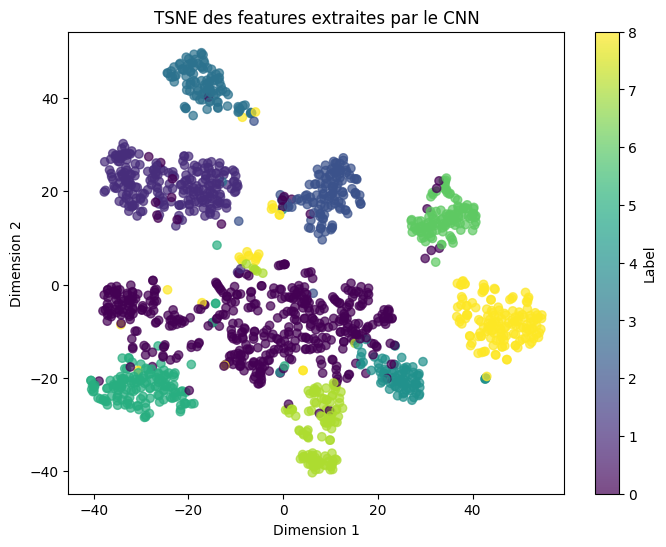

In [94]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1. Charger le modèle CNN pré-entraîné
model_path = "/content/best_model_test_min6.h5"
model = tf.keras.models.load_model(model_path)
print("Modèle CNN chargé depuis :", model_path)

# 2. Créer le feature extractor (on prend la sortie de la 3ème dernière couche)
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
print("Feature extractor créé.")

# 3. Fonction pour extraire les features depuis un dataset
def extract_features(dataset, extractor):
    features = []
    labels = []
    for images, labs in dataset:
        feats = extractor.predict(images)
        features.append(feats)
        labels.append(labs.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Remplacez 'full_ds' par votre tf.data.Dataset contenant vos images et labels
print("Extraction des features sur l'ensemble full_ds...")
features, labels = extract_features(full_ds, feature_extractor)
print("Shape des features extraites :", features.shape)
print("Nombre de samples :", features.shape[0])

# 4. Appliquer TSNE pour réduire la dimension à 2
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)
print("TSNE terminée. Shape TSNE :", features_2d.shape)

# 5. Afficher le TSNE
plt.figure(figsize=(8,6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label')
plt.title("TSNE des features extraites par le CNN")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

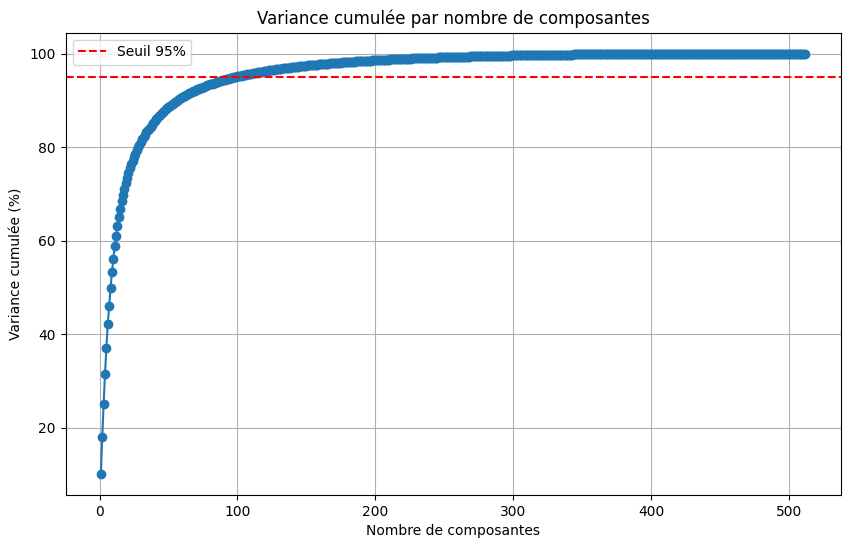

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Supposons que "features" est votre matrice de features extraite par le CNN
# features.shape = (nombre_d'échantillons, n_features)
# Par exemple, n_features pourrait être 512.

# Réaliser l'ACP sur l'ensemble des features
pca = PCA(n_components=features.shape[1])
pca.fit(features)

# Calculer la variance cumulée en pourcentage
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100

# Afficher le graphique
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance cumulée (%)")
plt.title("Variance cumulée par nombre de composantes")
plt.axhline(y=95, color='r', linestyle='--', label='Seuil 95%')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf

# Chemin vers le modèle entraîné
model_path = "/content/drive/MyDrive/challenge_deep/modele entrainé/best_model_test_min6.h5"

# Chargement du modèle CNN
cnn_model = tf.keras.models.load_model(model_path)
print("Modèle CNN chargé avec succès !")

# Création du feature extractor à partir de la 3ème dernière couche (à ajuster si nécessaire)
feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)
print("Feature extractor créé avec succès !")

Modèle CNN chargé avec succès !
Feature extractor créé avec succès !


In [76]:
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
import os

#####################################
# 0. Charger le meilleur modèle CNN
#####################################
# Assurez-vous d'avoir défini ou importé F1Macro si c'était une métrique custom
# par exemple :
# from my_metrics_module import F1Macro
# (ou d'autres custom_objects si nécessaires)

model_path = "/content/best_model_test_min6.h5"

# Si vous aviez un custom F1Macro :
# custom_objs = {"F1Macro": F1Macro(num_classes=9)}
# model = tf.keras.models.load_model(model_path, custom_objects=custom_objs)

model = tf.keras.models.load_model(model_path)
print(f"Modèle CNN chargé depuis : {model_path}")

#####################################
# Paramètres globaux
#####################################
NUM_CLASSES = 9
HIGH_WEIGHT = 3.0  # Surpondération de classes minoritaires (ex. 4 et 7)

#####################################
# 1. Construire le feature_extractor
#####################################
# On prend la sortie de la couche -3 (par exemple Dense(512, relu) ou BN)
feature_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-3].output
)
print("Feature extractor construit.")

#####################################
# 2. Fonction pour extraire les features
#####################################
def extract_features(dataset, extractor):
    all_feats = []
    all_labels = []
    for images, labs in dataset:
        feats = extractor.predict(images)
        all_feats.append(feats)
        all_labels.append(labs.numpy())
    features = np.concatenate(all_feats, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    return features, labels

#####################################
# 3. Extraire les features depuis full_ds
#####################################
print("Extraction des features sur l'ensemble full_ds...")
all_features, all_labels = extract_features(full_ds, feature_extractor)
print("Shape des features extraites :", all_features.shape)
print("Nombre de samples :", all_features.shape[0])

#####################################
# 4. Split interne (80% train, 20% validation) pour Optuna
#####################################
X_train, X_valid, y_train, y_valid = train_test_split(
    all_features,
    all_labels,
    test_size=0.20,
    random_state=42,
    stratify=all_labels
)
print("Taille X_train:", X_train.shape)
print("Taille X_valid:", X_valid.shape)

#####################################
# 5. Optuna objective
#####################################
def objective(trial):
    # Hyperparamètres
    params = {
        'objective': 'multi:softprob',
        'num_class': NUM_CLASSES,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'gamma': trial.suggest_float('gamma', 1e-3, 1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Surpondération de classes 4 et 7
    sample_weights = np.ones_like(y_train, dtype=float)
    sample_weights[y_train == 4] = HIGH_WEIGHT
    sample_weights[y_train == 7] = HIGH_WEIGHT

    clf = xgb.XGBClassifier(**params)
    clf.fit(
        X_train, y_train,
        sample_weight=sample_weights,
        verbose=False
    )

    y_pred = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred, average='macro')
    return score

#####################################
# 6. Lancement de l'optimisation
#####################################
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
best_trial = study.best_trial
print("  F1 Macro sur validation (optimisation): {:.4f}".format(best_trial.value))
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

#####################################
# 7. Réentraînement final sur 100% de full_ds
#####################################
best_params = dict(best_trial.params)
best_params.update({
    'objective': 'multi:softprob',
    'num_class': NUM_CLASSES,
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'random_state': 42
})

sample_weights_full = np.ones_like(all_labels, dtype=float)
sample_weights_full[all_labels == 4] = HIGH_WEIGHT
sample_weights_full[all_labels == 7] = HIGH_WEIGHT

xgb_clf_final = xgb.XGBClassifier(**best_params)
xgb_clf_final.fit(
    all_features, all_labels,
    sample_weight=sample_weights_full,
    verbose=False
)

print("\nRéentraînement final terminé sur la totalité du full_ds !")
print("Aucune évaluation finale supplémentaire, car il n'y a plus de dataset de test distinct.")

Modèle CNN chargé depuis : /content/best_model_test_min6.h5
Feature extractor construit.
Extraction des features sur l'ensemble full_ds...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

[I 2025-04-02 02:46:57,393] A new study created in memory with name: no-name-2a6919dc-a888-4cca-90e5-3540ecf84355


Shape des features extraites : (1569, 512)
Nombre de samples : 1569
Taille X_train: (1255, 512)
Taille X_valid: (314, 512)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:46:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 02:47:08,937] Trial 0 finished with value: 0.9539916046364192 and parameters: {'max_depth': 3, 'learning_rate': 0.005404724782184246, 'n_estimators': 298, 'gamma': 0.08105863584001993, 'min_child_weight': 7, 'subsample': 0.9732292557094092, 'colsample_bytree': 0.8573794168597819}. Best is trial 0 with value: 0.9539916046364192.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:47:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 02:47:14,372] Trial 1 finished with value: 0.9633511558292169 and parameters: {'max_depth': 7, 'learning_rate': 0.017480727104459, 'n_estimators': 107, 'gamma': 0.02669999834684434, 'min_child_weight': 6, 'subsample': 

Best trial:
  F1 Macro sur validation (optimisation): 0.9760
  Best hyperparameters:
    max_depth: 3
    learning_rate: 0.0715199427186724
    n_estimators: 268
    gamma: 0.0013810909812806266
    min_child_weight: 9
    subsample: 0.5521235630443851
    colsample_bytree: 0.6239637540171143

Réentraînement final terminé sur la totalité du full_ds !
Aucune évaluation finale supplémentaire, car il n'y a plus de dataset de test distinct.


test logit

In [80]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

# Paramètres globaux
TEST_FOLDER = "/content/drive/MyDrive/challenge_deep/dataset/test/datatest"
TARGET_HEIGHT = 800
TARGET_WIDTH  = 800
NUM_CLASSES = 9

def load_and_preprocess_image(filepath):
    """
    Charge une image depuis le disque, la redimensionne avec padding à TARGET_HEIGHT x TARGET_WIDTH,
    et normalise les valeurs de pixels dans [0,1].
    """
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0  # Normalisation
    return image

# Récupérer la liste de toutes les images de test
test_files = [os.path.join(TEST_FOLDER, f) for f in os.listdir(TEST_FOLDER) if f.lower().endswith('.jpg')]
print(f"Found {len(test_files)} test images.")

# Extraction des features pour chaque image test
test_features = []
test_ids = []

# On suppose que 'feature_extractor' est déjà défini (issue de votre modèle CNN entraîné)
for filepath in test_files:
    image = load_and_preprocess_image(filepath)
    image = tf.expand_dims(image, axis=0)  # Ajouter une dimension batch
    feats = feature_extractor.predict(image)
    test_features.append(feats)
    idx = os.path.splitext(os.path.basename(filepath))[0]  # Nom du fichier sans extension
    test_ids.append(idx)

# Concaténer toutes les features en un tableau numpy
test_features = np.concatenate(test_features, axis=0)
print("Test features shape:", test_features.shape)

# Obtenir les probabilités pour chaque classe via le modèle XGBoost (xgb_clf_final)
probs = xgb_clf_final.predict_proba(test_features)

# Préparer les prédictions sous forme de dictionnaire
predictions = []
for idx, prob_row in zip(test_ids, probs):
    pred_dict = {"idx": idx}
    for j in range(NUM_CLASSES):
        pred_dict[f"logit_class_{j}"] = float(prob_row[j])
    predictions.append(pred_dict)

# Convertir la liste de prédictions en DataFrame et sauvegarder en CSV
pred_df = pd.DataFrame(predictions)
output_csv = "/content/drive/MyDrive/challenge_deep/predictions/predictions_v6_kaggle.csv"
pred_df.to_csv(output_csv, index=False)
print(f"Prédictions sauvegardées dans '{output_csv}'.")

Found 1344 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [79]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

# Chemin vers le dossier de test (images non étiquetées)
TEST_FOLDER = "/content/drive/MyDrive/challenge_deep/dataset/test/datatest"

# Taille cible pour le redimensionnement (idem que pour l'entraînement)
TARGET_HEIGHT = 800
TARGET_WIDTH  = 800

def load_and_preprocess_image(filepath):
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0
    return image

# Lister et trier les fichiers .jpg
test_files = [f for f in os.listdir(TEST_FOLDER) if f.lower().endswith('.jpg')]
test_files = sorted(test_files)
test_files = [os.path.join(TEST_FOLDER, f) for f in test_files]

print(f"Found {len(test_files)} test images.")

test_features = []
test_ids = []

for filepath in test_files:
    # Prétraiter
    image = load_and_preprocess_image(filepath)
    image = tf.expand_dims(image, axis=0)

    # Extraire features
    feats = feature_extractor.predict(image)
    test_features.append(feats)

    # Nom du fichier sans extension
    idx = os.path.splitext(os.path.basename(filepath))[0]
    test_ids.append(idx)

test_features = np.concatenate(test_features, axis=0)
print("Test features shape:", test_features.shape)

# Prédiction XGBoost
pred_labels = xgb_clf_final.predict(test_features)

# Préparer le DataFrame
predictions = []
for file_id, label in zip(test_ids, pred_labels):
    predictions.append({'idx': file_id, 'gt': int(label)})

pred_df = pd.DataFrame(predictions)
pred_df = pred_df.sort_values(by='idx')  # si besoin, tri par 'id'

# Sauvegarde CSV
output_csv = "/content/drive/MyDrive/challenge_deep/predictions_xgboostP2.csv"
pred_df.to_csv(output_csv, index=False)
print(f"Saved {output_csv}")

Found 1344 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

#Test Yvan


In [97]:
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# ===========================================
# PARAMÈTRES GLOBAUX
# ===========================================
NUM_CLASSES = 9         # Nombre total de classes
N_TRIALS = 50           # Nombre d'essais pour l'optimisation Optuna

# ===========================================
# 1. Chargement du full train depuis le CSV
# ===========================================
full_train_csv = "/content/train_convnext_features.csv"
df_full = pd.read_csv(full_train_csv)
print("Shape du full train :", df_full.shape)

# Séparation des features et des labels
X_full = df_full.drop(columns=["label"])
y_full = df_full["label"]

# ===========================================
# 2. Création des splits :
#     - On réserve 20% pour le test final
#     - Et on divise le reste en train (80%) et validation (20%) pour l'optimisation Optuna
# ===========================================
X_temp, X_test_final, y_temp, y_test_final = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42, stratify=y_full
)
print("Taille du jeu de test final :", X_test_final.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.20, random_state=42, stratify=y_temp
)
print("Taille X_train :", X_train.shape)
print("Taille X_valid :", X_valid.shape)

# ===========================================
# 3. Définition de la fonction objectif pour Optuna
# ===========================================
def objective(trial):
    # Définition des hyperparamètres à optimiser
    params = {
        'objective': 'multi:softprob',
        'num_class': NUM_CLASSES,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'gamma': trial.suggest_float('gamma', 1e-3, 1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Entraînement du modèle XGBoost sur le split train
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    # Prédiction sur le jeu de validation et calcul du score macro-F1
    y_pred_valid = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred_valid, average='macro')
    return score

# Lancement d'Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

print("\n=== Meilleur essai Optuna ===")
best_trial = study.best_trial
print(f"Meilleur score macro-F1 sur validation : {best_trial.value:.4f}")
print("Hyperparamètres retenus :")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# ===========================================
# 4. Entraînement final sur l'ensemble du training (X_temp) et évaluation sur le test final
# ===========================================
best_params = dict(best_trial.params)
best_params.update({
    'objective': 'multi:softprob',
    'num_class': NUM_CLASSES,
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'random_state': 42
})

xgb_clf_final = xgb.XGBClassifier(**best_params)
xgb_clf_final.fit(X_temp, y_temp, verbose=False)

# Évaluation sur le jeu de test final
y_pred_test = xgb_clf_final.predict(X_test_final)
final_f1 = f1_score(y_test_final, y_pred_test, average='macro')

print("\n=== Évaluation finale sur le jeu de test final ===")
print(f"Score macro-F1 sur le test final : {final_f1:.4f}")
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred_test))

[I 2025-04-02 04:48:14,914] A new study created in memory with name: no-name-618f0616-444b-4a74-a877-745736ea21a2


Shape du full train : (1390, 1025)
Taille du jeu de test final : (278, 1024)
Taille X_train : (889, 1024)
Taille X_valid : (223, 1024)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:48:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 04:48:21,731] Trial 0 finished with value: 0.9943697216140132 and parameters: {'max_depth': 8, 'learning_rate': 0.04194935886848905, 'n_estimators': 148, 'gamma': 0.8871596808022565, 'min_child_weight': 9, 'subsample': 0.5357507952121795, 'colsample_bytree': 0.7291004831792718}. Best is trial 0 with value: 0.9943697216140132.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:48:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-02 04:48:30,505] Trial 1 finished with value: 0.9943697216140132 and parameters: {'max_depth': 6, 'learning_rate': 0.04475717317626071, 'n_estimators': 270, 'gamma': 0.6107692857214406, 'min_child_weight': 6, 'subsample': 0


=== Meilleur essai Optuna ===
Meilleur score macro-F1 sur validation : 1.0000
Hyperparamètres retenus :
  max_depth: 9
  learning_rate: 0.04860803776120402
  n_estimators: 215
  gamma: 0.08634744710184035
  min_child_weight: 4
  subsample: 0.8901238171777256
  colsample_bytree: 0.549366200140381


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:00:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Évaluation finale sur le jeu de test final ===
Score macro-F1 sur le test final : 0.9885

Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        86
           1       1.00      0.98      0.99        41
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        15
           5       1.00      0.96      0.98        26
           6       0.95      1.00      0.98        20
           7       1.00      0.95      0.98        21
           8       1.00      1.00      1.00        27

    accuracy                           0.99       278
   macro avg       0.99      0.99      0.99       278
weighted avg       0.99      0.99      0.99       278



#)labéllisé

In [ ]:
import os
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf

########################################
# PARTIE 1 : OPTIMISATION & ENTRAÎNEMENT SUR FULL TRAIN
########################################

# PARAMÈTRES GLOBAUX
NUM_CLASSES = 9         # Nombre total de classes
N_TRIALS = 50           # Nombre d'essais pour l'optimisation Optuna

# 1. Chargement du full train depuis le CSV
full_train_csv = "/content/train_convnext_features.csv"
df_full = pd.read_csv(full_train_csv)
print("Shape du full train :", df_full.shape)

# Séparation des features et du label
X_full = df_full.drop(columns=["label"])
y_full = df_full["label"]

# 2. Création des splits :
#    - On réserve 20% pour le test final
#    - Le reste est divisé en training (80%) et validation (20%) pour l'optimisation Optuna
X_temp, X_test_final, y_temp, y_test_final = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42, stratify=y_full
)
print("Taille du jeu de test final :", X_test_final.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.20, random_state=42, stratify=y_temp
)
print("Taille X_train :", X_train.shape)
print("Taille X_valid :", X_valid.shape)

# 3. Optimisation avec Optuna sur le split train/validation
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': NUM_CLASSES,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'gamma': trial.suggest_float('gamma', 1e-3, 1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    y_pred_valid = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred_valid, average='macro')
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

print("\n=== Meilleur essai Optuna ===")
best_trial = study.best_trial
print(f"Meilleur score macro-F1 sur validation : {best_trial.value:.4f}")
print("Hyperparamètres retenus :")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# 4. Réentraînement final sur l'ensemble complet du full train
best_params = dict(best_trial.params)
best_params.update({
    'objective': 'multi:softprob',
    'num_class': NUM_CLASSES,
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'random_state': 42
})

xgb_clf_final = xgb.XGBClassifier(**best_params)
xgb_clf_final.fit(X_full, y_full, verbose=False)

# Évaluation sur le jeu de test final issu du full train
y_pred_test = xgb_clf_final.predict(X_test_final)
final_f1 = f1_score(y_test_final, y_pred_test, average='macro')
print("\n=== Évaluation finale sur le jeu de test final ===")
print(f"Score macro-F1 sur le test final : {final_f1:.4f}")
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred_test))


In [98]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

# Chemin vers le dossier de test (images non étiquetées)
TEST_FOLDER = "/content/drive/MyDrive/challenge_deep/dataset/test/datatest"

# Taille cible pour le redimensionnement (idem que pour l'entraînement)
TARGET_HEIGHT = 800
TARGET_WIDTH  = 800

def load_and_preprocess_image(filepath):
    """
    Charge une image depuis le disque, la redimensionne avec padding pour TARGET_HEIGHT x TARGET_WIDTH,
    et normalise les valeurs de pixels dans [0,1].
    """
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    # Redimensionner avec padding pour préserver le ratio d'aspect
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0  # Normalisation
    return image

# Récupérer la liste de toutes les images de test
test_files = [os.path.join(TEST_FOLDER, f) for f in os.listdir(TEST_FOLDER) if f.lower().endswith('.jpg')]
print(f"Found {len(test_files)} test images.")

# Extraction des features via le feature extractor pour chaque image de test
# (On suppose que 'feature_extractor' et 'xgb_clf_final' sont déjà définis et entraînés)
test_features = []
test_ids = []

for filepath in test_files:
    # Charger et prétraiter l'image
    image = load_and_preprocess_image(filepath)
    # Ajouter une dimension de batch
    image = tf.expand_dims(image, axis=0)
    # Extraire les features avec le feature extractor
    feats = feature_extractor.predict(image)
    test_features.append(feats)
    # Extraire l'identifiant (nom du fichier sans extension)
    idx = os.path.splitext(os.path.basename(filepath))[0]
    test_ids.append(idx)

# Concaténer les features en un tableau numpy
test_features = np.concatenate(test_features, axis=0)
print("Test features shape:", test_features.shape)

# Utiliser le classificateur XGBoost pour prédire sur ces features
pred_labels = xgb_clf_final.predict(test_features)

# Préparer les prédictions dans un DataFrame
predictions = []
for idx, label in zip(test_ids, pred_labels):
    predictions.append({'idx': idx, 'gt': int(label)})

pred_df = pd.DataFrame(predictions)

# Enregistrer le CSV sous le nom predictions_v5.csv dans votre Drive
output_csv = "/content/drive/MyDrive/challenge_deep/predictions_v7.csv"
pred_df.to_csv(output_csv, index=False)
print("Saved predictions_v7.csv")

Found 1344 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

ValueError: Feature shape mismatch, expected: 1024, got 512